## Getting Ready: Imports & Util Functions

In [1]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from matplotlib.pyplot import figure
import plotly.express as px
from mplcursors import cursor  # separate package must be installed
from os import listdir

import utils

from dash import Dash, dcc, html, Input, Output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.tools as tls

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Returns a cleaned up dataframe with columns dropped and column names converted into 'variable name' like format
def do_basic_cleanup(df, drop_cols):
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns})
    try:
      df = df.drop(columns=drop_cols)
    except Exception as e:
      print(e)
    return df

def filter_df(df, item, metric, area, year=0):
    return df[(df.value > 0.0) & (df.item == item) & (df.element == metric) & (df.area == area) & (df.year >= year)]

def get_df_from_dir(dir_name, cols_to_drop=[]):
    df = pd.DataFrame()
    for file in listdir(dir_name):
      try:
          df_part = pd.read_csv(f"{dir_name}/" + file, on_bad_lines='warn')
          df_part = do_basic_cleanup(df_part, cols_to_drop)
          print(file, df_part.shape)
          df = pd.concat([df, df_part], ignore_index=True)
      except Exception as e:
         print(e)
    return df

In [5]:
df = get_df_from_dir('data', ['domain_code', 'area_code_m49', 'element_code', 'item_code_cpc', 'year_code', 'note', 'flag'])
print('Number of unique countries:', len(df.area.unique()))

FAOSTAT_data_en_4-28-2024_Port_Swe.csv (41402, 8)
FAOSTAT_data_en_5-4-2024_smaller_countries.csv (63759, 8)
FAOSTAT_data_en_4-28-2024_Ger_Neth.csv (55646, 8)
FAOSTAT_data_en_4-28-2024_Aust_Fin.csv (46988, 8)
FAOSTAT_data_en_5-4-2024_eastern_eur.csv (52769, 8)
FAOSTAT_data_en_4-28-2024_IRL.csv (6452, 8)
Number of unique countries: 27


In [5]:
df.value = df.value.astype('int64')
df.shape
df.head()

(267016, 8)

,domain,area,element,item,year,unit,value,flag_description
0,Crops and livestock products,Portugal,Area harvested,"Almonds, in shell",1961,ha,37000,Estimated value
1,Crops and livestock products,Portugal,Yield,"Almonds, in shell",1961,100 g/ha,4324,Estimated value
2,Crops and livestock products,Portugal,Production,"Almonds, in shell",1961,t,16000,Official figure
3,Crops and livestock products,Portugal,Area harvested,"Almonds, in shell",1962,ha,38000,Estimated value
4,Crops and livestock products,Portugal,Yield,"Almonds, in shell",1962,100 g/ha,4737,Estimated value


In [6]:
df.unit.value_counts()

unit
t           107630
ha           88906
100 g/ha     70480
Name: count, dtype: int64

In [7]:
def calc_means(df):
  df = df[['item', 'element', 'area', 'value']]
  return df.groupby(by=['item', 'element', 'area'], as_index=False).mean()

means_df = calc_means(df).rename(columns={'value': 'all_time_mean'})
means_df.all_time_mean = means_df.all_time_mean.apply(lambda x: round(x, 2))

means_df = means_df.reset_index()
means_df.shape
means_df.head()

(6697, 5)

,index,item,element,area,all_time_mean
0,0,"Almonds, in shell",Area harvested,Belgium,0.00
1,1,"Almonds, in shell",Area harvested,Bulgaria,894.61
2,2,"Almonds, in shell",Area harvested,Croatia,574.45
3,3,"Almonds, in shell",Area harvested,Cyprus,4970.48
4,4,"Almonds, in shell",Area harvested,Estonia,0.00


In [8]:
df = df.merge(means_df, on=['item', 'element', 'area'])
df.shape

(267016, 10)

In [9]:
percentiles = pd.DataFrame()

PERCENTILE_LABELS = ["0-25%", "25-50%", "50-75%", "75-100%"]

for el in df.element.unique().tolist():
  for area in df.area.unique().tolist():
    q = df[(df.element == el) & (df.area == area)][['item', 'element', 'area', 'all_time_mean']].drop_duplicates()
    q['percentile'] = pd.qcut(df.value, np.linspace(0,1,5), labels=PERCENTILE_LABELS)
    q = q.drop(columns=['all_time_mean'])
    percentiles = pd.concat([percentiles, q], ignore_index=True)

percentiles = percentiles.reset_index(drop=True)
percentiles.shape
percentiles.head()


(6697, 4)

,item,element,area,percentile
0,"Almonds, in shell",Area harvested,Portugal,50-75%
1,Apples,Area harvested,Portugal,50-75%
2,Apricots,Area harvested,Portugal,25-50%
3,Artichokes,Area harvested,Portugal,0-25%
4,Asparagus,Area harvested,Portugal,0-25%


In [10]:
df = df.merge(percentiles, on=['item', 'element', 'area'])
df.shape

(267016, 11)

In [11]:
df.tail()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,percentile
267011,Crops and livestock products,Ireland,Production,Wheat,2018,t,485480,Official figure,6630,529232.56,75-100%
267012,Crops and livestock products,Ireland,Production,Wheat,2019,t,595360,Official figure,6630,529232.56,75-100%
267013,Crops and livestock products,Ireland,Production,Wheat,2020,t,364920,Official figure,6630,529232.56,75-100%
267014,Crops and livestock products,Ireland,Production,Wheat,2021,t,628080,Official figure,6630,529232.56,75-100%
267015,Crops and livestock products,Ireland,Production,Wheat,2022,t,701240,Official figure,6630,529232.56,75-100%


In [12]:
df.describe()

,year,value,index,all_time_mean
count,267016.000000,2.670160e+05,267016.000000,2.670160e+05
mean,1994.723885,2.075236e+05,3381.658496,2.075236e+05
std,17.666619,1.226368e+06,1940.839557,1.151618e+06
min,1961.000000,0.000000e+00,0.000000,0.000000e+00
25%,1980.000000,5.520000e+02,1673.000000,1.370340e+03
50%,1997.000000,1.191100e+04,3347.000000,1.482889e+04
75%,2010.000000,7.390325e+04,5088.000000,8.171274e+04
max,2022.000000,5.192821e+07,6696.000000,2.807130e+07


In [13]:
d = df[(df.value > 0.0) & (df.unit == 't') & (df['percentile'] == '75-100%')]
d.head()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,percentile
2899,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1961,t,82000,Official figure,1423,35103.69,75-100%
2900,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1962,t,96000,Official figure,1423,35103.69,75-100%
2901,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1963,t,64000,Official figure,1423,35103.69,75-100%
2902,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1964,t,90000,Official figure,1423,35103.69,75-100%
2903,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1965,t,47000,Official figure,1423,35103.69,75-100%


In [14]:
top_irish_crops = data=df[(df.value > 0.0) & (df.area == 'Ireland') & (df['percentile'] == '75-100%')]

In [15]:
TOP_IRISH_CROPS_PRODUCTION = top_irish_crops[top_irish_crops.element == 'Production'].item.unique()
TOP_IRISH_CROPS_PRODUCTION

TOP_IRISH_CROPS_AREA = top_irish_crops[top_irish_crops.element == 'Area harvested'].item.unique()
TOP_IRISH_CROPS_AREA

TOP_IRISH_CROPS_YIELD= top_irish_crops[top_irish_crops.element == 'Yield'].item.unique()
TOP_IRISH_CROPS_YIELD

array(['Barley', 'Beer of barley, malted', 'Oats', 'Potatoes',
       'Raw cane or beet sugar (centrifugal only)', 'Sugar beet', 'Wheat'],
      dtype=object)

array(['Barley', 'Oats', 'Potatoes', 'Wheat'], dtype=object)

array(['Apples', 'Cabbages', 'Carrots and turnips',
       'Cauliflowers and broccoli', 'Cucumbers and gherkins', 'Currants',
       'Leeks and other alliaceous vegetables', 'Lettuce and chicory',
       'Onions and shallots, dry (excluding dehydrated)',
       'Other beans, green', 'Other vegetables, fresh n.e.c.', 'Potatoes',
       'Pumpkins, squash and gourds', 'Spinach', 'Sugar beet', 'Tomatoes'],
      dtype=object)

<Figure size 960x480 with 0 Axes>

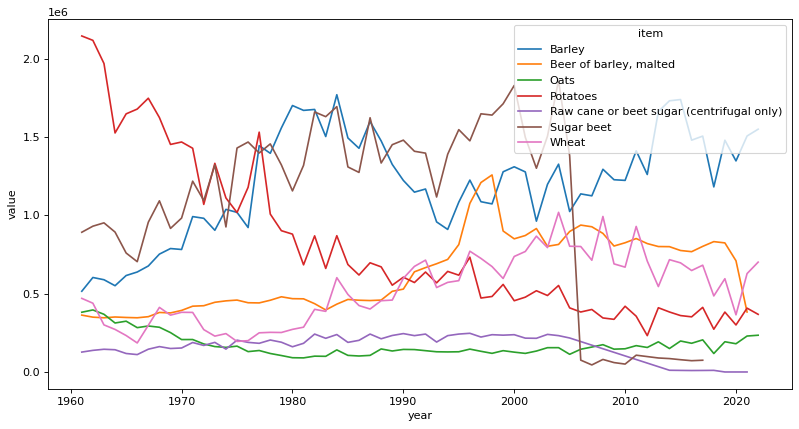

In [16]:
figure(figsize=(12, 6), dpi=80)
_ = sns.lineplot(data=top_irish_crops[top_irish_crops.element == 'Production'], x='year', y='value', hue='item')
_ = plt.show()

From: https://plotly.com/python/line-charts/

In [86]:
app = Dash(__name__)

app.layout = html.Div([
    html.Div([
        html.Div([
            dcc.Dropdown(
                id="area",
                options=df.area.unique(),
                value="Ireland",
            ),
            dcc.RadioItems(
                PERCENTILE_LABELS,
                PERCENTILE_LABELS[-1],
                id="percentile",
                inline=True,
            )
        ], style={'width': '40%', 'display': 'inline-block'}),
    ]),
    dcc.Graph(id="line-graph"),
    dcc.Graph(id="bar-graph"),
])


@app.callback([
    Output("line-graph", "figure"), 
    Output("bar-graph", "figure")], 
    Input("percentile", "value"),
    Input("area", "value"))
def update_line_chart(percentile, area):
    data=df[(df.value > 0.0) & (df.unit == 't') & (df.area == area) & (df.percentile == percentile)]
    return (px.line(data, x="year", y="value", color='item', title=f"{percentile} Crops Production in {area}"), 
            px.bar(data, x="year", y="value", color="item", title=f"{percentile} Crops Production in {area}"))


app.run_server(debug=True, port=8072)

In [ ]:
app_comp = Dash(__name__)

app_comp.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id="item",
            options=list(set(TOP_IRISH_CROPS_PRODUCTION.tolist() + TOP_IRISH_CROPS_YIELD.tolist())),
            value="Barley",
        ),
    ], style={'width': '42%', 'display': 'inline-block', "borderColor": "#66c2a5"}),
    html.Div([
        dcc.Dropdown(
            id="metric",
            options=df.element.unique(),
            value="Production",
        ),
    ], style={'width': '42%', 'display': 'inline-block', "borderColor": "#66c2a5"}),
    html.Div([
            dcc.Checklist(
                id="areas",
                options=df.area.unique(),
                value=["Belgium", "Ireland"]
            ),
        ], style={'width': '15%', 'float': 'right', 'display': 'inline-block', "backgroundColor": "#fafbfc"}),
    html.Div([
        html.Div([
           dcc.Graph(id="graph"),
        ], style={'width': '84%', 'float': 'left'}),
    ])
])


@app_comp.callback(
    Output("graph", "figure"), 
    Input("item", "value"),
    Input("metric", "value"),
    Input("areas", "value"))
def update_line_chart(item, metric, areas):
    data=df[(df.value > 0.0) & 
            (df.item == item) & 
            (df.element == metric) & 
            (df.area.isin(areas))]
    return px.line(data, x="year", y="value", color='area')


app_comp.run_server(debug=True, port=8051)

In [18]:
df_unstacked = df.pivot(index=['year', 'area', 'item'], columns='element', values='value').reset_index(['year', 'area', 'item'])
df_unstacked.head()

ELEMENTS = ['Area harvested', 'Production', 'Yield']

element,year,area,item,Area harvested,Production,Yield
0,1961,Austria,Apples,0.0,456000.0,NaN
1,1961,Austria,Apricots,0.0,33952.0,NaN
2,1961,Austria,Asparagus,35.0,150.0,42857.0
3,1961,Austria,Barley,187648.0,511571.0,27262.0
4,1961,Austria,"Beans, dry",682.0,1160.0,17009.0


In [19]:
top_irish_crops.tail()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,percentile
267011,Crops and livestock products,Ireland,Production,Wheat,2018,t,485480,Official figure,6630,529232.56,75-100%
267012,Crops and livestock products,Ireland,Production,Wheat,2019,t,595360,Official figure,6630,529232.56,75-100%
267013,Crops and livestock products,Ireland,Production,Wheat,2020,t,364920,Official figure,6630,529232.56,75-100%
267014,Crops and livestock products,Ireland,Production,Wheat,2021,t,628080,Official figure,6630,529232.56,75-100%
267015,Crops and livestock products,Ireland,Production,Wheat,2022,t,701240,Official figure,6630,529232.56,75-100%


In [20]:
top_irish_crops_unstacked = top_irish_crops.pivot(index=['year', 'area', 'item'], columns='element', values='value').reset_index(['year', 'area', 'item'])
top_irish_crops_unstacked.tail()
top_irish_crops_unstacked.shape

element,year,area,item,Area harvested,Production,Yield
1009,2022,Ireland,Potatoes,8490.0,367950.0,433392.0
1010,2022,Ireland,"Pumpkins, squash and gourds",NaN,NaN,63846.0
1011,2022,Ireland,Spinach,NaN,NaN,100000.0
1012,2022,Ireland,Tomatoes,NaN,NaN,3690000.0
1013,2022,Ireland,Wheat,67230.0,701240.0,NaN


(1014, 6)

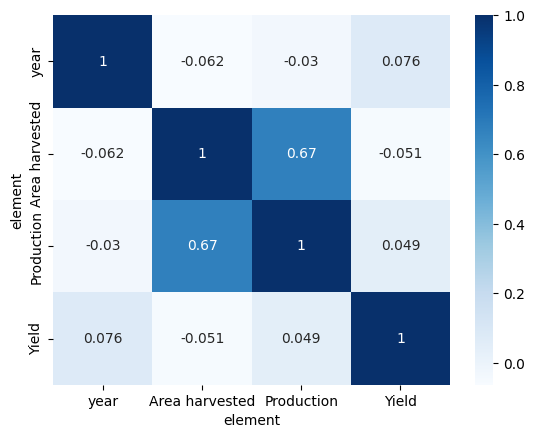

In [21]:
corr = df_unstacked[['year', 'Area harvested', 'Production', 'Yield']].dropna().corr()
sns.heatmap(corr, cmap="Blues", annot=True);

We can see a 0.67 correlation between Area harvested & Production, which means that potentially one of these variables can be discarded for future ML purposes.

In [22]:
df_unstacked.head()

element,year,area,item,Area harvested,Production,Yield
0,1961,Austria,Apples,0.0,456000.0,NaN
1,1961,Austria,Apricots,0.0,33952.0,NaN
2,1961,Austria,Asparagus,35.0,150.0,42857.0
3,1961,Austria,Barley,187648.0,511571.0,27262.0
4,1961,Austria,"Beans, dry",682.0,1160.0,17009.0


<Figure size 550x550 with 0 Axes>

Text(0.5, 1.0, 'Barley production & Yield in Ireland 1961-2022')

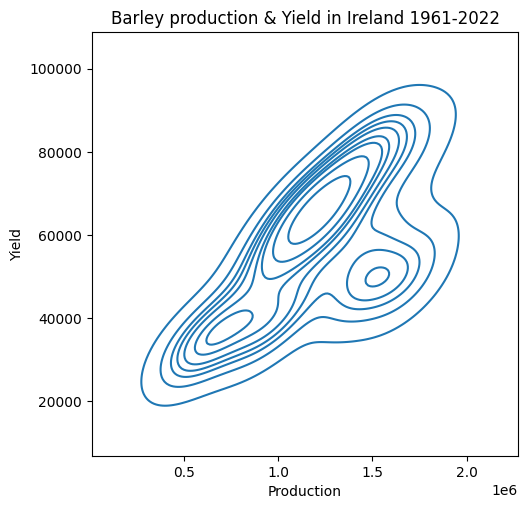

In [23]:
plt.figure(figsize=(5.5, 5.5))

irl_braley_prod = df_unstacked[(df_unstacked.area == 'Ireland') & (df_unstacked.item == 'Barley')]

g = sns.kdeplot(irl_braley_prod, x='Production', y='Yield')
g.set_title('Barley production & Yield in Ireland 1961-2022')
#plt.savefig('plots/ch1/B07887_01_02.png', format='png', dpi=300)

## Statistics

In [24]:
#Importing libraries

import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats import weightstats

#Importing the libraries
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy as scipy

from statsmodels.tsa.stattools import adfuller


In [25]:
# https://www.kaggle.com/code/brekhnaa/analysis-of-variance-anova

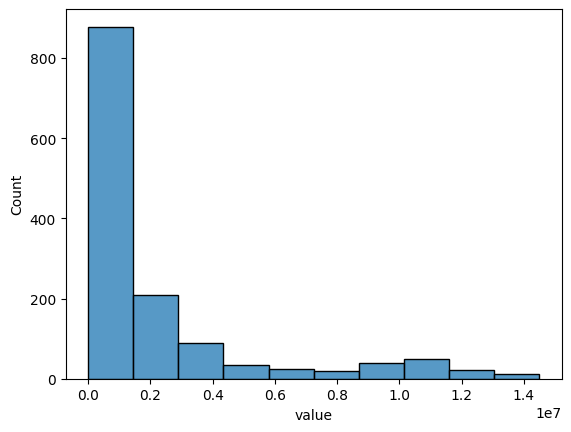

In [26]:
barley_data = df[(df.element == 'Production') & (df.item == 'Barley')]
_ = sns.histplot(data=barley_data, x='value', bins=10)


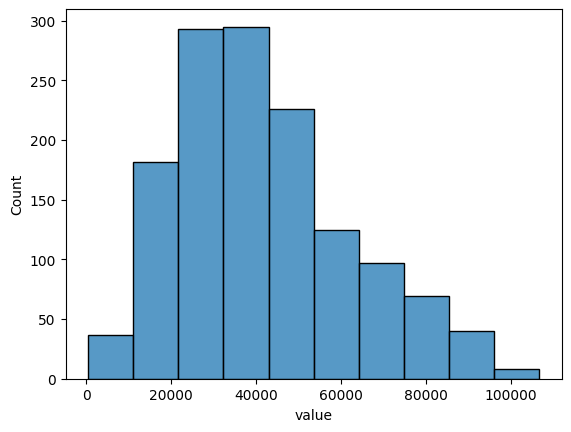

In [27]:
wheat_yield = df[(df.value > 0.0) & (df.item == 'Wheat') & (df.element == 'Yield')]
_ = sns.histplot(data=wheat_yield, x='value', bins=10)


In [28]:
def filter_df(df, item, metric, area, year):
    return df[(df.value > 0.0) & (df.item == item) & (df.element == metric) & (df.area == area) & (df.year >= year)]

Based on the graph above epxlore similarities between barley production in Ireland vs Sweden

In [29]:
# Barley Sweden vs Ireland

X1 = filter_df(df, 'Barley', 'Production', 'Ireland', 1961)
X2 = filter_df(df, 'Barley', 'Production', 'Sweden', 1961)

t_test_barley = stats.ttest_ind(X1.value, X2.value, equal_var = False)
t_test_barley

TtestResult(statistic=-8.274887082484733, pvalue=2.108363734344893e-13, df=119.35353288843136)

As pvalue is lower than alpha, we reject the null hypothesis.

**Interpretation**: With a 5% significance level, there is enough evidence to say that there are differences between Itish and Swedish barley production as observed from year 1961 until 2022.

In [30]:
# Barley Sweden vs Ireland post 2006
X1 = filter_df(df, 'Barley', 'Production', 'Ireland', 2006)
X2 = filter_df(df, 'Barley', 'Production', 'Sweden', 2006)

t_test_barley = stats.ttest_ind(X1.value, X2.value, equal_var = False)
t_test_barley

TtestResult(statistic=-1.1251166718413368, pvalue=0.2692174781299017, df=30.849374886060687)

As pvalue is higher than alpha, we **accept** the null hypothesis.

**Interpretation**: With a 5% significance level, there is enough evidence to say that there are NO differences between Itish and Swedish barley production as observed from year 2006 until 2022.

Assumption is that one of the contributing factors could be introduction of CAP.

In [31]:

# Oats Czechia vs Ireland post 2006
X1 = filter_df(df, 'Oats', 'Production', 'Ireland', 2006)
X2 = filter_df(df, 'Oats', 'Production', 'Czechia', 2006) 

t_test_oats = stats.ttest_ind(X1.value, X2.value, equal_var = False)
t_test_oats

TtestResult(statistic=2.1492199461011676, pvalue=0.04159312462200444, df=24.746714809060233)

### Check whether Barley production in Ireland is normally distributed.
Null Hypothesis H0: Barley production in Ireland follows normal distribution.

In [32]:
k2, p = stats.normaltest(filter_df(df, 'Barley', 'Production', 'Ireland', 1961).value)
alpha = 0.05
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.199551
The null hypothesis cannot be rejected


Check if wheat yield in Ireland is normally distributed

In [33]:
k2, p = stats.normaltest(df[(df.value > 0.0) & (df.area == 'Ireland') & (df.item == 'Wheat') & (df.element == 'Yield')].value)
alpha = 0.05
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 2.01955e-05
The null hypothesis can be rejected


In [34]:
df_unstacked.head()

element,year,area,item,Area harvested,Production,Yield
0,1961,Austria,Apples,0.0,456000.0,NaN
1,1961,Austria,Apricots,0.0,33952.0,NaN
2,1961,Austria,Asparagus,35.0,150.0,42857.0
3,1961,Austria,Barley,187648.0,511571.0,27262.0
4,1961,Austria,"Beans, dry",682.0,1160.0,17009.0


/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_85408/4154315805.py:11: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



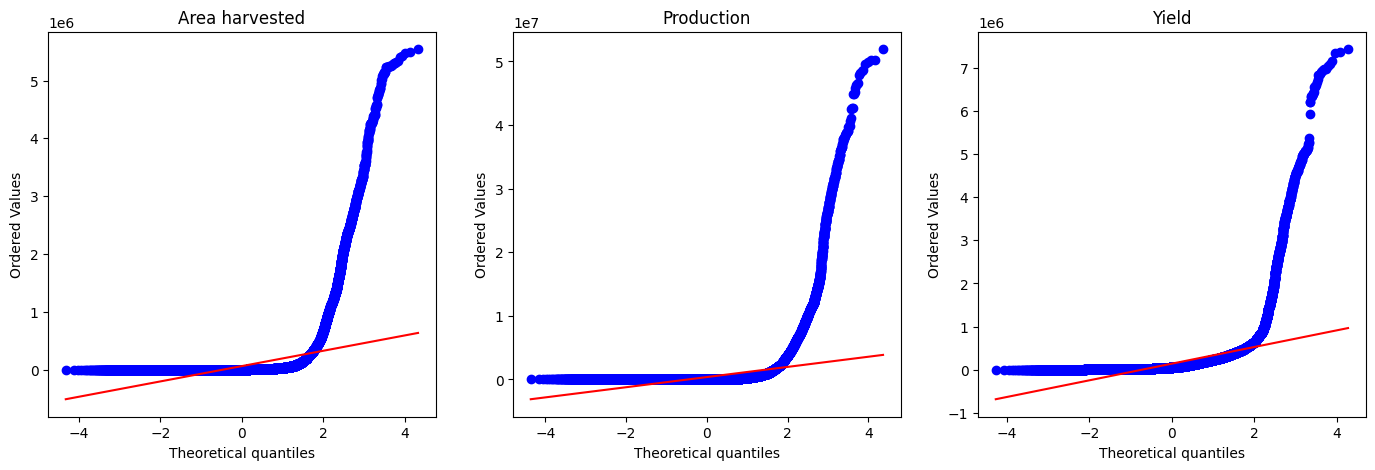

In [35]:
#Check normality of the data for Production & Yield & Area Harvested
# Probability plot - QQ plot
# https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html

f, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, element in enumerate(ELEMENTS):
   _ = stats.probplot(df_unstacked[element].dropna(), plot=axes[i]);
   _ = axes[i].set_title(element);
  #plt.figure();
f.show()

/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_85408/427128009.py:7: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



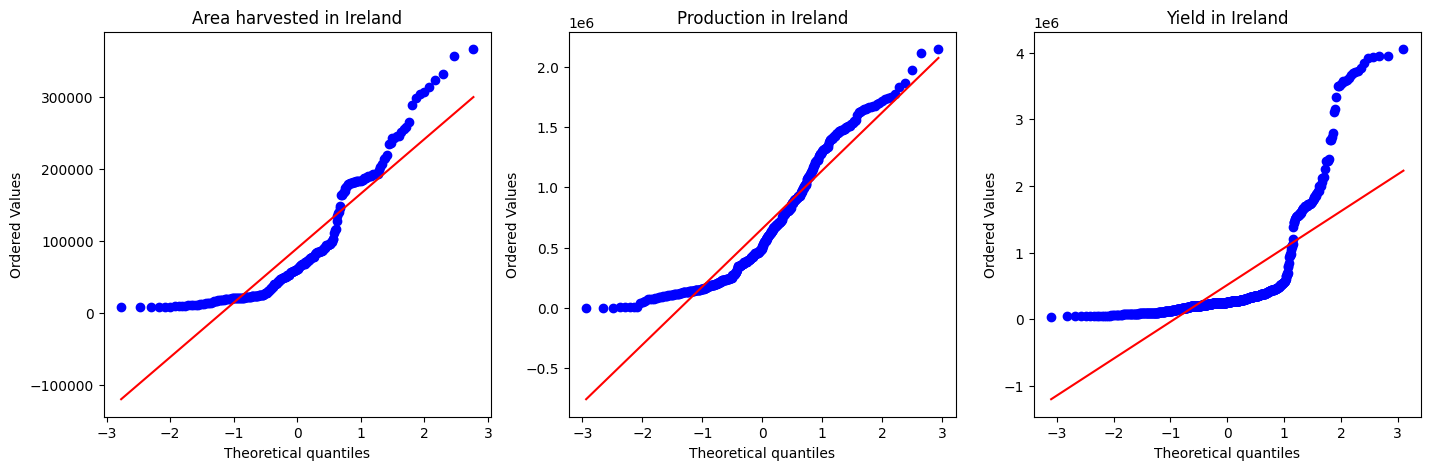

In [36]:
f, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, element in enumerate(ELEMENTS):
   _ = stats.probplot(top_irish_crops_unstacked[element].dropna(), plot=axes[i]);
   _ = axes[i].set_title(element + ' in Ireland');
  #plt.figure();
f.show()

/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_85408/3692659371.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



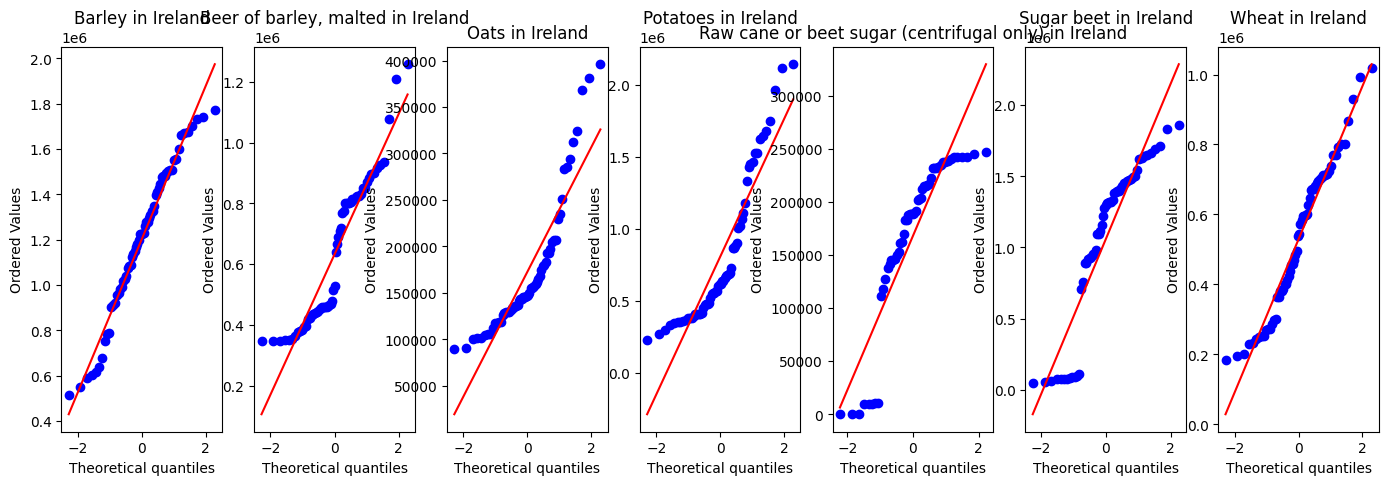

In [37]:
f, axes = plt.subplots(1, len(TOP_IRISH_CROPS_PRODUCTION), figsize=(17, 5))

for j, crop in enumerate(TOP_IRISH_CROPS_PRODUCTION):
    data = top_irish_crops_unstacked[top_irish_crops_unstacked.item == crop]["Production"].dropna()
    if data.shape[0] > 10:
      _ = stats.probplot(data, plot=axes[j]);
    _ = axes[j].set_title(crop + ' in Ireland');
  #plt.figure();
f.show()

/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_85408/2789467027.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



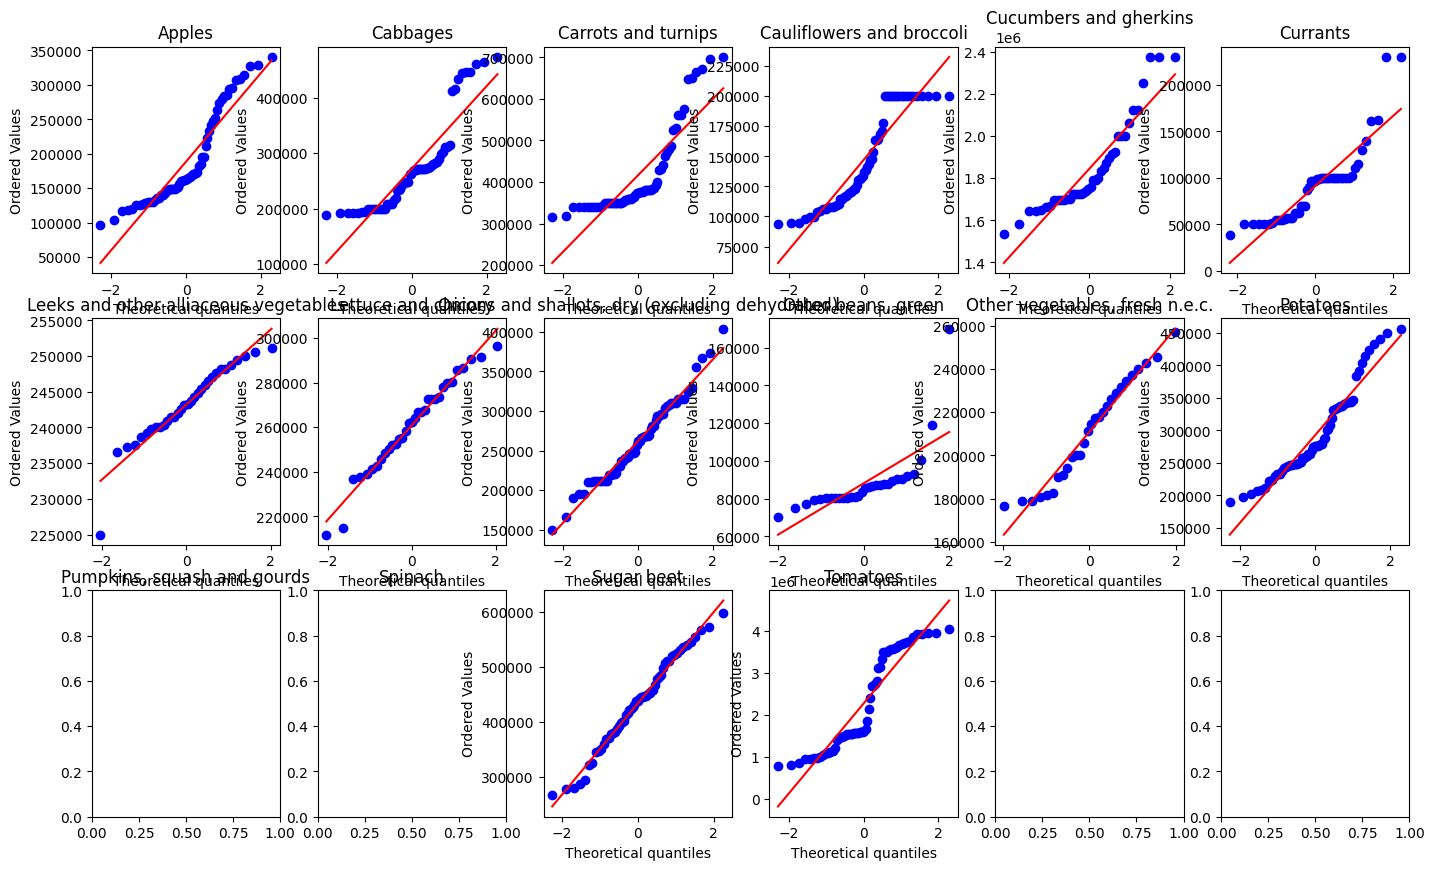

In [38]:
import math

cols = math.ceil(len(TOP_IRISH_CROPS_YIELD)/3)
i = 0
f, axes = plt.subplots(3, cols, figsize=(17, 10))


for j, crop in enumerate(TOP_IRISH_CROPS_YIELD):
    data = top_irish_crops_unstacked[top_irish_crops_unstacked.item == crop]["Yield"].dropna()
    
    row = math.floor(j/cols)
    if i > 5:
      i = 0
    col = i
    i += 1

    if data.shape[0] > 10:
      _ = stats.probplot(data, plot=axes[row , col]);
    _ = axes[row, col].set_title(crop);
  #plt.figure();
f.show()

In [39]:
df_unstacked = df_unstacked.dropna()

In [40]:
# Shapiro Wilk Test - Normality test
# This test is hypothesis test that will hel design if the data is normal or not
# H0 - data normally distributed
# H1 - data NOT normally distributed

SHAPIRO_MAX_SAMPLE = 5000

for element in ELEMENTS:
   res = stats.shapiro(df_unstacked[element].dropna())
   print(f"{element}: {res}")
    
   res_sampled = stats.shapiro(df_unstacked[element].dropna().sample(n=SHAPIRO_MAX_SAMPLE, random_state=1))
   print(f"{element}, sampled: {res_sampled}")

   print("Pvalue difference of ", res.pvalue - res_sampled.pvalue, "\n")


Area harvested: ShapiroResult(statistic=0.23145123632085662, pvalue=2.782968286839086e-165)
Area harvested, sampled: ShapiroResult(statistic=0.25756006502015516, pvalue=6.259060549683202e-89)
Pvalue difference of  -6.259060549683202e-89 

Production: ShapiroResult(statistic=0.20682108608568373, pvalue=2.4864725507380968e-166)
Production, sampled: ShapiroResult(statistic=0.23131058984414032, pvalue=1.0057674410013623e-89)
Pvalue difference of  -1.0057674410013623e-89 

Yield: ShapiroResult(statistic=0.3178338093048261, pvalue=2.3924122830009124e-161)
Yield, sampled: ShapiroResult(statistic=0.28240777591341726, pvalue=3.723304637212965e-88)
Pvalue difference of  -3.723304637212965e-88 



/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_85408/1981336570.py:9: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 70480.



**Interpretation**: Reject hypothesis, becasue P is smaller than Alpha

In [41]:
top_irish_crops.head()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,percentile
260636,Crops and livestock products,Ireland,Yield,Apples,1961,100 g/ha,96667,Estimated value,157,188430.4,75-100%
260637,Crops and livestock products,Ireland,Yield,Apples,1962,100 g/ha,103333,Estimated value,157,188430.4,75-100%
260638,Crops and livestock products,Ireland,Yield,Apples,1963,100 g/ha,116667,Estimated value,157,188430.4,75-100%
260639,Crops and livestock products,Ireland,Yield,Apples,1964,100 g/ha,120000,Estimated value,157,188430.4,75-100%
260640,Crops and livestock products,Ireland,Yield,Apples,1965,100 g/ha,140000,Estimated value,157,188430.4,75-100%


In [213]:
# Now we can analyse normality by Product and Category (yield / production)

%prun

# Define the default alpha
alpha = 0.05

results = []
for item in TOP_IRISH_CROPS_PRODUCTION:
    for area in df_unstacked.area.unique():
        crop_df = df_unstacked[(df_unstacked.item == item) & (df_unstacked.area == area)]
        for element in ELEMENTS:
            crop_el_df = crop_df[element]
            if crop_el_df.shape[0] < 3:
                continue
            res_sampled = stats.shapiro(crop_el_df)
            # if res_sampled.pvalue < alpha, then null hypothesis: x comes from a normal distribution
            results.append([item, area, element, crop_df.shape[0], res_sampled.pvalue, not (res_sampled.pvalue < alpha)])

         3 function calls in 0.001 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.001    0.001 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)

In [43]:
shapiro_per_category = pd.DataFrame(data=results, columns=['item', 'area', 'element', 'sample_size', 'pval', 'is_normal'])
shapiro_per_category.shape

(393, 6)

In [44]:
@interact
def show_articles_more_than(is_normal=True):
    return shapiro_per_category[shapiro_per_category.is_normal == is_normal]

interactive(children=(Checkbox(value=True, description='is_normal'), Output()), _dom_classes=('widget-interact…

##### Levene Test
Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

The Levene test is less sensitive than the Bartlett test to departures from normality. If you have strong evidence that your data do in fact come from a normal, or nearly normal, distribution, then Bartlett's test has better performance.
https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm#:~:text=Levene's%20test%20is%20an%20alternative,Bartlett's%20test%20has%20better%20performance.

In [45]:
# Levene test on Barley Yield
dfs = [filter_df(df, 'Barley', 'Yield', 'Ireland', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'Germany', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'France', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'Belgium', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'Denmark', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'Netherlands (Kingdom of the)', 2006).value]

stats.levene(*dfs, center = 'mean')
stats.bartlett(*dfs)

LeveneResult(statistic=1.3615854886536825, pvalue=0.24563360972459522)

BartlettResult(statistic=5.5483829539909, pvalue=0.352669678198435)

**Interpretation**: accept that all inout samples are from populations with equal variances.

In [46]:
stats.levene(filter_df(df, 'Oats', 'Production', 'Ireland', 2006).value, 
            filter_df(df, 'Oats', 'Production', 'Czechia', 2006).value, 
            center = 'mean')

LeveneResult(statistic=5.874194676640041, pvalue=0.02119514502306541)

In [47]:
# ANOVA ######
# H0: Average cgarges the same for all locations
# H1: There is at least one average difference than others
# ols('X~categorical variable')

data = df_unstacked[df_unstacked.area.isin(['Ireland', 'Germany', 'France', 'Belgium', 'Denmark', 'Netherlands (Kingdom of the)'])]

model = ols('Yield~area', data=data).fit()
aov = sm.stats.anova_lm(model, type=2)
aov

,df,sum_sq,mean_sq,F,PR(>F)
area,5.0,2.666526e+14,5.333053e+13,140.457877,5.941663e-146
Residual,14373.0,5.457292e+15,3.796906e+11,NaN,NaN


**Conclusion** At 5% significance level there is NOT enough evidence to suggest that the average yilds are the same across the countries.
Reject the Null hypothesis

### Stationary vs Nonstationary data for time series analysis

Stationarity. A common assumption in many time series techniques is that the data are stationary. A stationary process has the property that the mean, variance and autocorrelation structure do not change over time.

Resources:
1. Concise explanation of implications: https://medium.com/@ritusantra/stationarity-in-time-series-887eb42f62a9
2. Time Series Analysis and Its Applications: With R Examples, Third Edition, by Robert H. Shumway and David S. Stoffer, Springer Verlag.
3. Time Series Analysis and Forecasting by Example, 1st Edition, by Søren Bisgaard and Murat Kulahci, John Wiley & Sons.
4. Practical Time Series Analysis: Prediction with Statistics and Machine Learning Paperback – 1 Nov. 2019
5. https://github.com/PacktPublishing/Practical-Time-Series-Analysis

In [48]:
result = adfuller(df_unstacked['Yield'].values)
result
print('p-value: %s' % result[1])

(-30.07013755882016,
 0.0,
 61,
 70418,
 {'1%': -3.4304428674258367,
  '5%': -2.8615810457572604,
  '10%': -2.5667918472534064},
 1989151.5613137127)

p-value: 0.0


In [49]:
result = adfuller(df_unstacked[(df_unstacked.area == 'Ireland') & (df_unstacked.item == 'Barley')]['Yield'].values)
result
print('p-value: %s' % result[1])

(-0.706200183985643,
 0.8451370071772577,
 3,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 1017.7347966818014)

p-value: 0.8451370071772577


## Time Series

In [4]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from prophet import Prophet

from pandas import to_datetime
import warnings
import ipywidgets as widgets
from IPython.display import display
import param
from ipywidgets import interact, interact_manual

import panel as pn
from prophet.serialize import model_to_json, model_from_json


In [51]:
df_unstacked.head()
df_unstacked = df_unstacked.sort_values(by='year')
df_unstacked.head()


element,year,area,item,Area harvested,Production,Yield
2,1961,Austria,Asparagus,35.0,150.0,42857.0
3,1961,Austria,Barley,187648.0,511571.0,27262.0
4,1961,Austria,"Beans, dry",682.0,1160.0,17009.0
6,1961,Austria,"Broad beans and horse beans, dry",659.0,1635.0,24810.0
8,1961,Austria,Buckwheat,224.0,256.0,11429.0


element,year,area,item,Area harvested,Production,Yield
2,1961,Austria,Asparagus,35.0,150.0,42857.0
927,1961,Malta,"Onions and shallots, dry (excluding dehydrated)",330.0,2537.0,76879.0
933,1961,Malta,"Other vegetables, fresh n.e.c.",1640.0,11000.0,67073.0
938,1961,Malta,Potatoes,3296.0,25349.0,76908.0
939,1961,Malta,"Pumpkins, squash and gourds",403.0,1093.0,27122.0


In [52]:
def plot_timeseries_split(X, y, n_splits=3):
    folds = TimeSeriesSplit(n_splits=n_splits)

    f, ax = plt.subplots(nrows=n_splits, ncols=2, figsize=(16, 9))
    
    for i, (train_index, valid_index) in enumerate(folds.split(X)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
    
        _ = sns.lineplot(
            x=X_train, 
            y=y_train, 
            ax=ax[i,0], 
            color='dodgerblue', 
            label='train'
        )
        _ = sns.lineplot(
            x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
            y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
            ax=ax[i,1], 
            color='dodgerblue', 
            label='train'
        )
    
        for j in range(2):
            sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
        ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16);
        ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16);
    
    for i in range(n_splits):
        ax[i, 0].set_xlim([1961, 2024]);
        ax[i, 1].set_xlim([1961, 2024]);
        
    plt.tight_layout()
    plt.show()

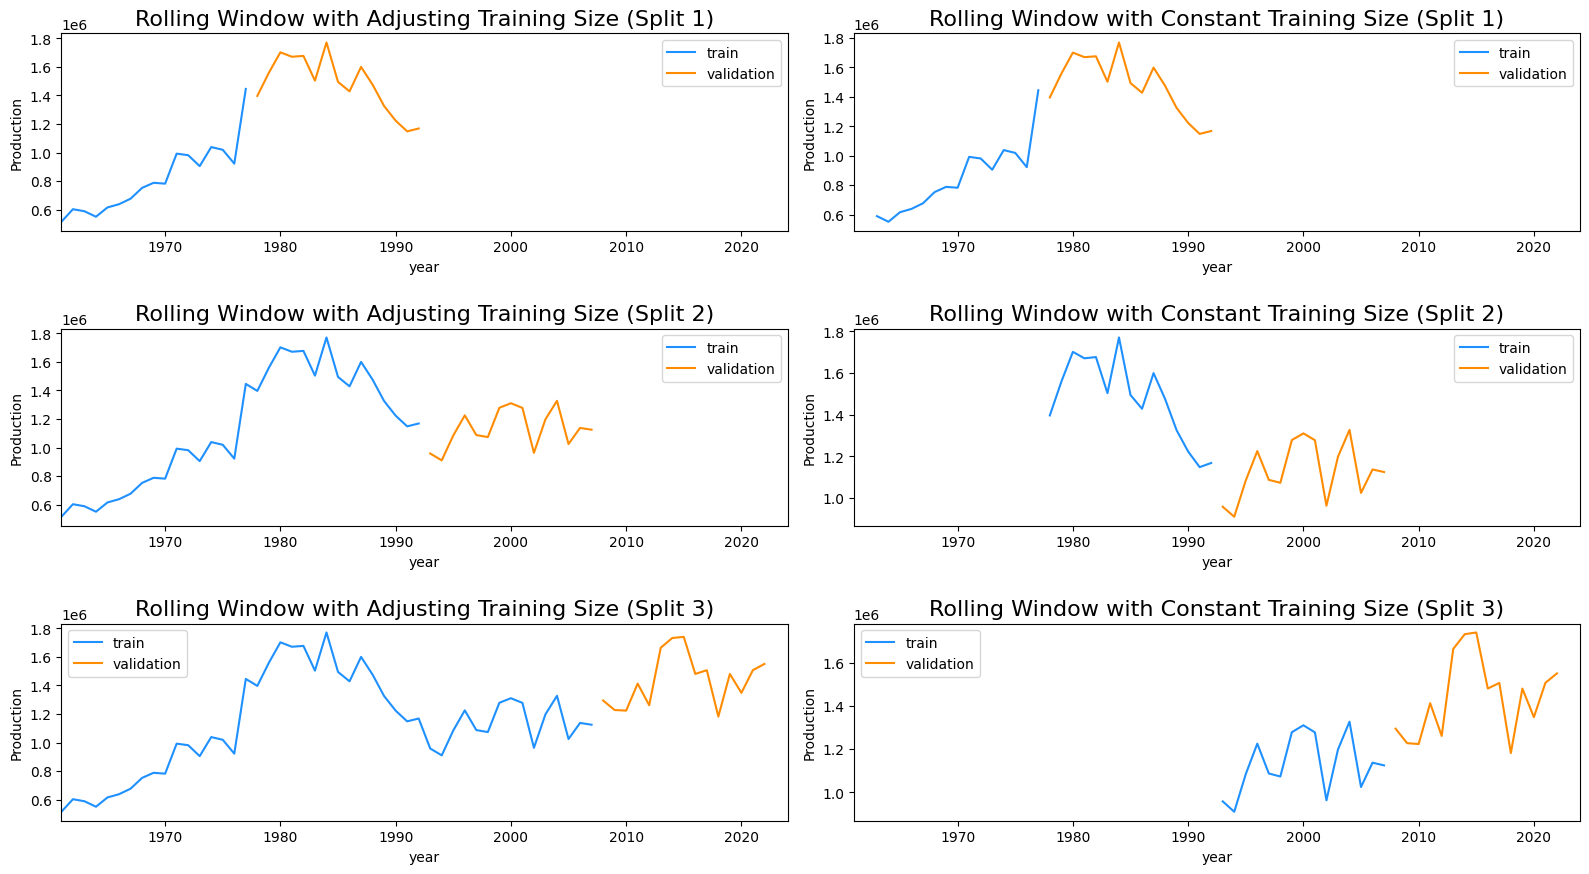

In [53]:
df_ireland_barley = df_unstacked[(df_unstacked.area == "Ireland") & (df_unstacked.item == "Barley")].reset_index().sort_values(by='year')

X = df_ireland_barley.year
y = df_ireland_barley.Production

plot_timeseries_split(X, y)

### Random Forest & Linear Regression on Time Series


https://www.ine.pt/revstat/pdf/Randomforestsfortimeseries.pdf

In [5]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression, Ridge


In [55]:
def split_and_prep_multivariate(X, y):
    train_size = int(0.75 * len(X))
        
    x_train, y_train = pd.DataFrame(X[:train_size]), pd.DataFrame(y[:train_size])
    x_valid, y_valid = pd.DataFrame(X[train_size:]), pd.DataFrame(y[train_size:])

    return x_train, y_train, x_valid, y_valid

In [56]:
def train_regressor(model, x_train, y_train, x_valid, y_valid):
    model.fit(x_train, y_train)
    print("Test-set R^2: {:.2f}".format(model.score(x_valid, y_valid)))
    
    y_pred_valid = model.predict(x_valid)
    y_pred_train = model.predict(x_train)
    
    train = x_train
    train['Ground Truth'] = y_train
    train['Predicted'] = y_pred_train

    validate = x_valid
    validate['Ground Truth'] = y_valid
    validate['Predicted'] = y_pred_valid

    return pd.concat([train, validate])

In [57]:
SCIKIT_CLASSIFIERS_RESULTS = {}
SCIKIT_CLASSIFIERS_MODELS = {}

In [58]:
### ~~~ Yield ~~~ ###

__metric = 'Yield'

In [59]:
__model = 'RandomForest'

SCIKIT_CLASSIFIERS_RESULTS[__model] = {}
SCIKIT_CLASSIFIERS_MODELS[__model] = {}

yield_multivariate_df = df_unstacked[(df_unstacked.area == "Ireland")].sort_values(by='year').reset_index()[['year', 'item', __metric]]

enc = OrdinalEncoder()
enc.fit(yield_multivariate_df[['item']])
yield_multivariate_df.item = enc.transform(yield_multivariate_df[['item']]) # instead of multivariate_df.item, need to do multivariate_df[['item']]), because OrdinalEncoder expect a Dataframe, and not a Series.

rf_model = RandomForestRegressor(n_estimators = 100, random_state = 0)

rf_results = train_regressor(rf_model, 
                          *split_and_prep_multivariate(yield_multivariate_df[['year', 'item']], yield_multivariate_df[__metric]))
rf_results.item = enc.inverse_transform(rf_results[['item']]).T[0] # Decode the crop values
rf_results = pd.melt(rf_results, id_vars=['year', 'item'], value_vars=['Ground Truth', 'Predicted'])

SCIKIT_CLASSIFIERS_RESULTS[__model]  = rf_results
SCIKIT_CLASSIFIERS_MODELS[__model] = rf_model


OrdinalEncoder()

/usr/local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Test-set R^2: 0.98


In [60]:
from sklearn.preprocessing import PolynomialFeatures

In [61]:
__model = 'LinearRegression'

SCIKIT_CLASSIFIERS_RESULTS[__model] = {}
SCIKIT_CLASSIFIERS_MODELS[__model] = {}

for crop in TOP_IRISH_CROPS_YIELD[:2]:
    yield_univariate_df = df_unstacked[(df_unstacked.area == "Ireland") & (df_unstacked.item == crop)].sort_values(by='year').reset_index()[['year', __metric]]
    
    name = f'{__metric}_Ireland_{crop}'

    x_train, y_train, x_valid, y_valid = split_and_prep_multivariate(yield_univariate_df['year'], yield_univariate_df[__metric])

    # Add polinomial features
    # poly_reg = PolynomialFeatures(degree=4)
    # X_train_poly = poly_reg.fit_transform(x_train)
    # x_valid_poly = poly_reg.transform(x_valid)

    l_reg_model = LinearRegression()
    results_lr = train_regressor(l_reg_model, x_train, y_train, x_valid, y_valid)
    
    results_lr = pd.melt(results_lr, id_vars=['year'], value_vars=['Ground Truth', 'Predicted'])

    SCIKIT_CLASSIFIERS_RESULTS[__model][name] = results_lr
    SCIKIT_CLASSIFIERS_MODELS[__model][name] = l_reg_model


Test-set R^2: -1.68
Test-set R^2: -87.05


<Axes: xlabel='year', ylabel='value'>

<Axes: xlabel='year', ylabel='value'>

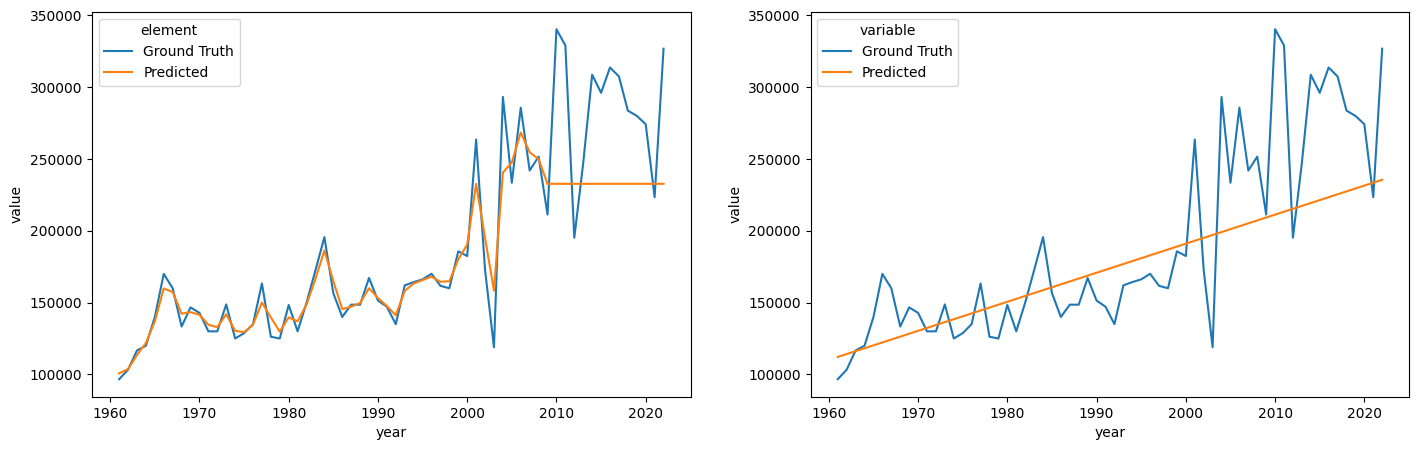

In [62]:
f, axes = plt.subplots(1, 2, figsize=(17, 5))

rf = SCIKIT_CLASSIFIERS_RESULTS['RandomForest']
sns.lineplot(data=rf[rf.item == 'Apples'], x='year', y='value', hue='element', ax=axes[0])

lr = SCIKIT_CLASSIFIERS_RESULTS['LinearRegression']['Yield_Ireland_Apples']
sns.lineplot(data=lr, x='year', y='value', hue='variable', ax=axes[1])

In [63]:
# (TODO: Olena) Re-do Linear Regression with Poly

Terminology: `yhat` - The estimated or predicted values in a regression or other predictive model are termed the y-hat values. “Y” because y is the outcome or dependent variable in the model equation, and a “hat” symbol (circumflex) placed over the variable name is the statistical designation of an estimated value.

### Meta (formerly, Facebook) open-source Prophet library

In [64]:
def split_and_prep_univariate(univariate_df):
    train_size = int(0.75 * len(univariate_df))
    
    univariate_df.year = to_datetime(univariate_df.year.apply(lambda x: str(x) + '-01-01'))
    univariate_df.columns = ['ds', 'y']
    
    train = univariate_df.iloc[:train_size, :]
    
    x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
    x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

    return train, x_train, y_train, x_valid, y_valid

In [65]:
def split_and_prep_multivariate(multivariate_df, target_column):
    feature_columns = [
      'item',
    ]
    
    train_size = int(0.85 * len(multivariate_df))
    
    multivariate_df = multivariate_df[['year'] + [target_column] + feature_columns].copy()
    multivariate_df.columns = ['ds', 'y'] + feature_columns
    
    train = multivariate_df.iloc[:train_size, :]
    x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
    x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])
    
    train.head()

    return train, x_train, y_train, x_valid, y_valid

In [66]:
#pip install prophet --no-binary :all:

In [67]:
warnings.filterwarnings("ignore")

def train_prophet(model, train, x_valid, y_valid):
    # Train the model
    model.fit(train)
        
    # Predict on valid set
    y_pred = model.predict(x_valid)    
    # Calcuate metrics
    score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
    score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

    return score_mae, score_rmse

In [68]:
def plot_prophet(model, x_valid, y_valid, y_label):

    y_pred = model.predict(x_valid)
    y_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    
    # Calcuate metrics
    score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
    score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))
    
    print('RMSE: {}'.format(score_rmse))
    # Plot the forecast
    f, ax = plt.subplots(1)
    f.set_figheight(3)
    f.set_figwidth(7)

    model.plot(y_pred, ax=ax)
    _ = sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')
    
    ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14);
    ax.set_xlabel(xlabel='Year', fontsize=8);
    ax.set_ylabel(ylabel=y_label, fontsize=8);

(46, 2)
46
46
16
16


(None, None, None, None, None)

13:44:59 - cmdstanpy - INFO - Chain [1] start processing
13:45:00 - cmdstanpy - INFO - Chain [1] done processing


(30890.55978432608, 38790.54759688486)

RMSE: 38790.54759688486


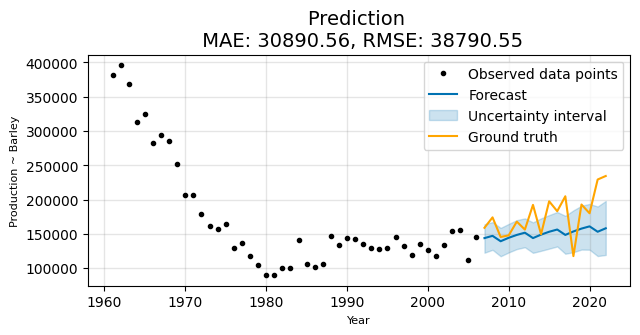

In [69]:
univariate_df = df_unstacked[(df_unstacked.area == "Ireland") & (df_unstacked.item == "Oats")].reset_index().sort_values(by='year')[['year', 'Production']]
train, x_train, y_train, x_valid, y_valid = split_and_prep_univariate(univariate_df)

print(train.shape), print(x_train.size), print(y_train.size), print(x_valid.size), print(y_valid.size)

model = Prophet(growth="linear")
train_prophet(model, train, x_valid, y_valid)
plot_prophet(model, x_valid, y_valid, 'Production ~ Barley')

In [70]:
# train_prophet_on_params will select the necessary training data from our main DF and train Meta Prophet model on that data
def train_prophet_on_params(area, item, metric):
    print(area, item, metric)
    univariate_df = df_unstacked[(df_unstacked.area == area) & (df_unstacked.item == item)].reset_index().sort_values(by='year')[['year', metric]]
    train, x_train, y_train, x_valid, y_valid = split_and_prep_univariate(univariate_df)
    print(train.shape, len(x_train), len(x_valid))
    
    model = Prophet(growth="linear")
    print(train_prophet(model, train, x_valid, y_valid))
    return model, x_valid, y_valid

In [71]:
AREAS = df_unstacked.area.unique()
ITEMS = TOP_IRISH_CROPS_PRODUCTION
METRICS = ['Production', 'Yield']

@interact
def show_articles_more_than(area=AREAS, item=ITEMS, metric=METRICS):
    try: 
        model, x_valid, y_valid = train_prophet_on_params(area, item, metric)
        plot_prophet(model, x_valid, y_valid, f'{area}_{item}_{metric}')
    except Exception as e:
        return print(f'\n Error creating Model for {area}, {item}, {metric}:', e)

interactive(children=(Dropdown(description='area', options=('Austria', 'Malta', 'Netherlands (Kingdom of the)'…

In [72]:

def pre_train(df_unstacked):
    validation_data = {}
    models = {}

    for metric in ['Yield', 'Production']: # Could optimize the code by moving this forloop into the innermost for loop, so the data for same crop + country can be retrived just once for both metrics
        for area in df_unstacked.area.unique():
            area_data = df_unstacked[(df_unstacked.area == area)].reset_index()
            area_data = area_data.dropna()
            for item in TOP_IRISH_CROPS_PRODUCTION.tolist():
                area_item_df_uni = area_data[(area_data.item == item)].reset_index().sort_values(by='year')[['year', metric]]
                name = f'{metric}_{area}_{item}'

                if len(area_item_df_uni) < 10:
                    models[name] = None
                    continue
                
                train, x_train, y_train, x_valid, y_valid = split_and_prep_univariate(area_item_df_uni)
                print(train.shape, len(x_train), len(x_valid))

                model = Prophet(growth="linear")
                print(train_prophet(model, train, x_valid, y_valid))
                
                # Saving each model to be able to easily restore all models without re-training and re-use / port them
                with open('prophet_models/' + f'{name}.json', 'w') as fout:
                    fout.write(model_to_json(model))  # Save model
    
                validation_data[name] = (x_valid, y_valid)
                models[name] = model
    
    return validation_data, models


In [73]:
def load_in_models(path):
    # TODO if I have time: loop over the provided path, open each file, load in all models into a dictionary and return, 
    # so it can be called like VALIDATION_DATA, TRAINED_MODELS = load_in_models('prophet_models')
    pass

### Benchmarking & Optimization

In [ ]:
# Train the models for EACH crop & country with the pre-chosen parameters.
# Estimate the time taken per run and loop
# pip install line_profiler
# pip install py-heat-magic

In [74]:
%timeit -r 2 -n 5
%lprun

VALIDATION_DATA, TRAINED_MODELS = pre_train(df_unstacked)

13:45:04 - cmdstanpy - INFO - Chain [1] start processing


(46, 2) 46 16


13:45:04 - cmdstanpy - INFO - Chain [1] done processing
13:45:05 - cmdstanpy - INFO - Chain [1] start processing


(4655.650316294386, 5253.419271904411)
(46, 2) 46 16


13:45:05 - cmdstanpy - INFO - Chain [1] done processing
13:45:05 - cmdstanpy - INFO - Chain [1] start processing
13:45:05 - cmdstanpy - INFO - Chain [1] done processing


(5562.645203730113, 6546.362767702324)
(46, 2) 46 16


13:45:05 - cmdstanpy - INFO - Chain [1] start processing


(24715.202726719723, 29238.114078325667)
(46, 2) 46 16


13:45:06 - cmdstanpy - INFO - Chain [1] done processing
13:45:06 - cmdstanpy - INFO - Chain [1] start processing


(52485.78071086955, 62526.42738345446)
(46, 2) 46 16


13:45:06 - cmdstanpy - INFO - Chain [1] done processing
13:45:07 - cmdstanpy - INFO - Chain [1] start processing


(4742.450273151765, 6361.265167743811)
(42, 2) 42 15


13:45:07 - cmdstanpy - INFO - Chain [1] done processing
13:45:07 - cmdstanpy - INFO - Chain [1] start processing


(1958.1171884566095, 2524.2265571886996)
(46, 2) 46 16


13:45:08 - cmdstanpy - INFO - Chain [1] done processing
13:45:08 - cmdstanpy - INFO - Chain [1] start processing


(99051.26278319629, 112160.87321661819)
(42, 2) 42 15


13:45:08 - cmdstanpy - INFO - Chain [1] done processing
13:45:08 - cmdstanpy - INFO - Chain [1] start processing


(4204.803692558829, 4567.306316875773)
(46, 2) 46 16


13:45:09 - cmdstanpy - INFO - Chain [1] done processing
13:45:09 - cmdstanpy - INFO - Chain [1] start processing
13:45:09 - cmdstanpy - INFO - Chain [1] done processing


(3702.1960807029823, 4526.375057495779)
(46, 2) 46 16


13:45:09 - cmdstanpy - INFO - Chain [1] start processing


(7072.436588897486, 8536.74070980978)
(46, 2) 46 16


13:45:10 - cmdstanpy - INFO - Chain [1] done processing
13:45:10 - cmdstanpy - INFO - Chain [1] start processing


(50689.35983652949, 60980.83607043382)
(46, 2) 46 16


13:45:10 - cmdstanpy - INFO - Chain [1] done processing
13:45:10 - cmdstanpy - INFO - Chain [1] start processing


(128277.10652997697, 139549.48634108185)
(46, 2) 46 16


13:45:10 - cmdstanpy - INFO - Chain [1] done processing
13:45:10 - cmdstanpy - INFO - Chain [1] start processing


(11417.743462046195, 13010.511324287534)
(46, 2) 46 16


13:45:11 - cmdstanpy - INFO - Chain [1] done processing
13:45:11 - cmdstanpy - INFO - Chain [1] start processing


(2079.971378509794, 2460.3295256213764)
(46, 2) 46 16


13:45:11 - cmdstanpy - INFO - Chain [1] done processing
13:45:11 - cmdstanpy - INFO - Chain [1] start processing


(3605.6417879030523, 3820.5940713850728)
(46, 2) 46 16


13:45:12 - cmdstanpy - INFO - Chain [1] done processing
13:45:12 - cmdstanpy - INFO - Chain [1] start processing


(19390.7570575223, 21347.440046516167)
(46, 2) 46 16


13:45:12 - cmdstanpy - INFO - Chain [1] done processing
13:45:12 - cmdstanpy - INFO - Chain [1] start processing


(65080.08816302699, 81428.038737125)
(46, 2) 46 16


13:45:13 - cmdstanpy - INFO - Chain [1] done processing
13:45:13 - cmdstanpy - INFO - Chain [1] start processing


(1542.4283392563161, 1884.1410056345524)
(46, 2) 46 16


13:45:13 - cmdstanpy - INFO - Chain [1] done processing
13:45:13 - cmdstanpy - INFO - Chain [1] start processing


(2941.8167108738944, 3730.6711635790675)
(46, 2) 46 16


13:45:14 - cmdstanpy - INFO - Chain [1] done processing
13:45:14 - cmdstanpy - INFO - Chain [1] start processing


(2193.868127556213, 2725.7978325620466)
(46, 2) 46 16


13:45:15 - cmdstanpy - INFO - Chain [1] done processing
13:45:15 - cmdstanpy - INFO - Chain [1] start processing


(65369.57897335495, 79160.24870158797)
(46, 2) 46 16


13:45:15 - cmdstanpy - INFO - Chain [1] done processing
13:45:15 - cmdstanpy - INFO - Chain [1] start processing


(160368.65680442442, 169904.3966248971)
(46, 2) 46 16


13:45:16 - cmdstanpy - INFO - Chain [1] done processing
13:45:16 - cmdstanpy - INFO - Chain [1] start processing


(5276.399785515061, 6252.547356250989)
(46, 2) 46 16


13:45:16 - cmdstanpy - INFO - Chain [1] done processing
13:45:16 - cmdstanpy - INFO - Chain [1] start processing


(6145.460547090674, 7327.165531877257)
(46, 2) 46 16


13:45:16 - cmdstanpy - INFO - Chain [1] done processing
13:45:17 - cmdstanpy - INFO - Chain [1] start processing


(2092.495062302425, 2565.004656683143)
(46, 2) 46 16


13:45:17 - cmdstanpy - INFO - Chain [1] done processing
13:45:17 - cmdstanpy - INFO - Chain [1] start processing


(17628.2019778548, 22649.845490869586)
(42, 2) 42 15


13:45:18 - cmdstanpy - INFO - Chain [1] done processing
13:45:18 - cmdstanpy - INFO - Chain [1] start processing
13:45:18 - cmdstanpy - INFO - Chain [1] done processing


(205881.10032255104, 227479.4812420944)
(46, 2) 46 16


13:45:18 - cmdstanpy - INFO - Chain [1] start processing


(4533.211662961918, 5202.122433339875)
(46, 2) 46 16


13:45:18 - cmdstanpy - INFO - Chain [1] done processing
13:45:18 - cmdstanpy - INFO - Chain [1] start processing


(6708.376583885394, 7974.910053172119)
(46, 2) 46 16


13:45:19 - cmdstanpy - INFO - Chain [1] done processing
13:45:19 - cmdstanpy - INFO - Chain [1] start processing
13:45:19 - cmdstanpy - INFO - Chain [1] done processing


(5578.275776801417, 6259.080784335338)
(46, 2) 46 16


13:45:19 - cmdstanpy - INFO - Chain [1] start processing


(21788.335583111548, 24565.614661289434)
(46, 2) 46 16


13:45:20 - cmdstanpy - INFO - Chain [1] done processing
13:45:20 - cmdstanpy - INFO - Chain [1] start processing


(101910.55883387386, 118362.32383890057)
(46, 2) 46 16


13:45:20 - cmdstanpy - INFO - Chain [1] done processing
13:45:20 - cmdstanpy - INFO - Chain [1] start processing


(5588.860069662953, 7459.199958962572)
(46, 2) 46 16


13:45:21 - cmdstanpy - INFO - Chain [1] done processing
13:45:21 - cmdstanpy - INFO - Chain [1] start processing


(5505.508027614205, 6983.1321484911105)
(46, 2) 46 16


13:45:21 - cmdstanpy - INFO - Chain [1] done processing
13:45:21 - cmdstanpy - INFO - Chain [1] start processing


(10319.437152823532, 12422.462015944866)
(46, 2) 46 16


13:45:21 - cmdstanpy - INFO - Chain [1] done processing
13:45:21 - cmdstanpy - INFO - Chain [1] start processing


(42396.82832544726, 53577.459136277146)
(42, 2) 42 15


13:45:22 - cmdstanpy - INFO - Chain [1] done processing
13:45:22 - cmdstanpy - INFO - Chain [1] start processing


(25185.564773841117, 36086.222374611556)
(46, 2) 46 16


13:45:22 - cmdstanpy - INFO - Chain [1] done processing
13:45:22 - cmdstanpy - INFO - Chain [1] start processing
13:45:23 - cmdstanpy - INFO - Chain [1] done processing


(17142.527250236883, 19961.847893800576)
(46, 2) 46 16


13:45:23 - cmdstanpy - INFO - Chain [1] start processing


(4993.696954548763, 5826.567551027882)
(46, 2) 46 16


13:45:23 - cmdstanpy - INFO - Chain [1] done processing
13:45:23 - cmdstanpy - INFO - Chain [1] start processing


(3719.17700566467, 4353.388284314883)
(46, 2) 46 16


13:45:24 - cmdstanpy - INFO - Chain [1] done processing
13:45:24 - cmdstanpy - INFO - Chain [1] start processing


(34843.08634568625, 41838.31648800128)
(46, 2) 46 16


13:45:25 - cmdstanpy - INFO - Chain [1] done processing
13:45:25 - cmdstanpy - INFO - Chain [1] start processing


(72122.48062468856, 88035.1418383043)
(46, 2) 46 16


13:45:26 - cmdstanpy - INFO - Chain [1] done processing
13:45:26 - cmdstanpy - INFO - Chain [1] start processing


(4381.965320925747, 5217.285928072162)
(46, 2) 46 16


13:45:27 - cmdstanpy - INFO - Chain [1] done processing
13:45:27 - cmdstanpy - INFO - Chain [1] start processing


(4850.606708807947, 6134.710653129843)
(46, 2) 46 16


13:45:27 - cmdstanpy - INFO - Chain [1] done processing
13:45:28 - cmdstanpy - INFO - Chain [1] start processing


(4249.5913783317355, 5689.867629958568)
(46, 2) 46 16


13:45:28 - cmdstanpy - INFO - Chain [1] done processing
13:45:28 - cmdstanpy - INFO - Chain [1] start processing


(24640.3653654764, 30081.006956245594)
(46, 2) 46 16


13:45:29 - cmdstanpy - INFO - Chain [1] done processing
13:45:29 - cmdstanpy - INFO - Chain [1] start processing


(113054.28478225633, 126536.2070306901)
(46, 2) 46 16


13:45:29 - cmdstanpy - INFO - Chain [1] done processing
13:45:29 - cmdstanpy - INFO - Chain [1] start processing


(6972.901214199231, 9702.763346195119)
(46, 2) 46 16


13:45:30 - cmdstanpy - INFO - Chain [1] done processing
13:45:30 - cmdstanpy - INFO - Chain [1] start processing


(6465.979676487201, 7808.8033347997025)
(46, 2) 46 16


13:45:30 - cmdstanpy - INFO - Chain [1] done processing


(2707.511602481638, 3093.209590333484)
(46, 2) 46 16


13:45:31 - cmdstanpy - INFO - Chain [1] start processing
13:45:31 - cmdstanpy - INFO - Chain [1] done processing
13:45:31 - cmdstanpy - INFO - Chain [1] start processing
13:45:31 - cmdstanpy - INFO - Chain [1] done processing


(15900.781240439077, 20924.81843720904)
(46, 2) 46 16


13:45:31 - cmdstanpy - INFO - Chain [1] start processing


(117670.06622895059, 127875.55685478963)
(46, 2) 46 16


13:45:32 - cmdstanpy - INFO - Chain [1] done processing
13:45:32 - cmdstanpy - INFO - Chain [1] start processing
13:45:32 - cmdstanpy - INFO - Chain [1] done processing


(7843.749972494496, 9067.814972887476)
(46, 2) 46 16
(7999.1532418667, 11072.796253440409)


13:45:32 - cmdstanpy - INFO - Chain [1] start processing


(46, 2) 46 16


13:45:33 - cmdstanpy - INFO - Chain [1] done processing
13:45:33 - cmdstanpy - INFO - Chain [1] start processing


(4688.94914517022, 5180.759057397327)
(46, 2) 46 16


13:45:33 - cmdstanpy - INFO - Chain [1] done processing
13:45:33 - cmdstanpy - INFO - Chain [1] start processing


(37404.350777622414, 43291.20917069456)
(46, 2) 46 16


13:45:33 - cmdstanpy - INFO - Chain [1] done processing
13:45:33 - cmdstanpy - INFO - Chain [1] start processing


(5977.0432191814525, 8887.41544195822)
(46, 2) 46 16


13:45:34 - cmdstanpy - INFO - Chain [1] done processing
13:45:34 - cmdstanpy - INFO - Chain [1] start processing


(8697.110577477495, 10439.535942199855)
(46, 2) 46 16


13:45:34 - cmdstanpy - INFO - Chain [1] done processing
13:45:35 - cmdstanpy - INFO - Chain [1] start processing


(3007.8409781763203, 3624.844035630811)
(46, 2) 46 16


13:45:35 - cmdstanpy - INFO - Chain [1] done processing
13:45:35 - cmdstanpy - INFO - Chain [1] start processing


(38702.995635308296, 44391.71346167366)
(35, 2) 35 12


13:45:35 - cmdstanpy - INFO - Chain [1] done processing
13:45:36 - cmdstanpy - INFO - Chain [1] start processing


(48873.55517920075, 60533.53302511527)
(46, 2) 46 16


13:45:36 - cmdstanpy - INFO - Chain [1] done processing
13:45:36 - cmdstanpy - INFO - Chain [1] start processing


(9158.445381988264, 11143.117783372172)
(46, 2) 46 16


13:45:36 - cmdstanpy - INFO - Chain [1] done processing
13:45:36 - cmdstanpy - INFO - Chain [1] start processing


(3852.421248063209, 5281.059889318915)
(46, 2) 46 16


13:45:37 - cmdstanpy - INFO - Chain [1] done processing
13:45:37 - cmdstanpy - INFO - Chain [1] start processing
13:45:37 - cmdstanpy - INFO - Chain [1] done processing


(4363.572462315674, 6484.959765947419)
(46, 2) 46 16


13:45:37 - cmdstanpy - INFO - Chain [1] start processing


(49845.0679397972, 57603.96260526757)
(46, 2) 46 16


13:45:38 - cmdstanpy - INFO - Chain [1] done processing
13:45:38 - cmdstanpy - INFO - Chain [1] start processing


(73566.93434590028, 87599.33301877388)
(46, 2) 46 16


13:45:38 - cmdstanpy - INFO - Chain [1] done processing
13:45:38 - cmdstanpy - INFO - Chain [1] start processing


(10029.963864343175, 11908.26329986727)
(46, 2) 46 16


13:45:39 - cmdstanpy - INFO - Chain [1] done processing
13:45:39 - cmdstanpy - INFO - Chain [1] start processing


(3507.4852288956577, 4905.984959142566)
(46, 2) 46 16


13:45:39 - cmdstanpy - INFO - Chain [1] done processing
13:45:39 - cmdstanpy - INFO - Chain [1] start processing


(3178.6810767446054, 4717.81895892743)
(46, 2) 46 16


13:45:39 - cmdstanpy - INFO - Chain [1] done processing
13:45:40 - cmdstanpy - INFO - Chain [1] start processing


(19751.568200508766, 21993.217258886165)
(46, 2) 46 16


13:45:40 - cmdstanpy - INFO - Chain [1] done processing
13:45:40 - cmdstanpy - INFO - Chain [1] start processing


(38885.23995870662, 52751.90296472775)
(46, 2) 46 16


13:45:41 - cmdstanpy - INFO - Chain [1] done processing
13:45:41 - cmdstanpy - INFO - Chain [1] start processing


(3886.541010650308, 5598.913726626383)
(46, 2) 46 16


13:45:41 - cmdstanpy - INFO - Chain [1] done processing
13:45:41 - cmdstanpy - INFO - Chain [1] start processing


(1267.6675933624585, 1696.4325630069186)
(46, 2) 46 16


13:45:42 - cmdstanpy - INFO - Chain [1] done processing
13:45:42 - cmdstanpy - INFO - Chain [1] start processing


(4600.040110585621, 7020.0020902122715)
(46, 2) 46 16


13:45:42 - cmdstanpy - INFO - Chain [1] done processing
13:45:42 - cmdstanpy - INFO - Chain [1] start processing


(37001.81661059515, 50999.47114771767)
(46, 2) 46 16


13:45:43 - cmdstanpy - INFO - Chain [1] done processing
13:45:43 - cmdstanpy - INFO - Chain [1] start processing


(59546.44686884625, 77925.12744748702)
(46, 2) 46 16


13:45:43 - cmdstanpy - INFO - Chain [1] done processing
13:45:43 - cmdstanpy - INFO - Chain [1] start processing


(1632.750844585499, 2116.4898677994333)
(46, 2) 46 16


13:45:44 - cmdstanpy - INFO - Chain [1] done processing
13:45:44 - cmdstanpy - INFO - Chain [1] start processing


(5306.5902517495615, 6438.370687810149)
(46, 2) 46 16


13:45:44 - cmdstanpy - INFO - Chain [1] done processing
13:45:44 - cmdstanpy - INFO - Chain [1] start processing


(9422.91407940428, 10344.58960454983)
(46, 2) 46 16


13:45:45 - cmdstanpy - INFO - Chain [1] done processing
13:45:45 - cmdstanpy - INFO - Chain [1] start processing


(45854.17854230288, 60540.94943533493)
(46, 2) 46 16


13:45:45 - cmdstanpy - INFO - Chain [1] done processing
13:45:45 - cmdstanpy - INFO - Chain [1] start processing


(72545.53197814026, 88226.52129439071)
(46, 2) 46 16


13:45:46 - cmdstanpy - INFO - Chain [1] done processing
13:45:46 - cmdstanpy - INFO - Chain [1] start processing


(12094.939385213076, 13952.565170387214)
(46, 2) 46 16


13:45:46 - cmdstanpy - INFO - Chain [1] done processing
13:45:46 - cmdstanpy - INFO - Chain [1] start processing


(12658.833916645213, 14744.90691926135)
(46, 2) 46 16


13:45:47 - cmdstanpy - INFO - Chain [1] done processing
13:45:47 - cmdstanpy - INFO - Chain [1] start processing
13:45:47 - cmdstanpy - INFO - Chain [1] done processing


(9064.55513562966, 10485.86646417783)
(46, 2) 46 16


13:45:47 - cmdstanpy - INFO - Chain [1] start processing


(56655.56794020081, 70089.93195868556)
(46, 2) 46 16


13:45:47 - cmdstanpy - INFO - Chain [1] done processing
13:45:47 - cmdstanpy - INFO - Chain [1] start processing


(80688.1606484938, 111591.34281747161)
(46, 2) 46 16


13:45:48 - cmdstanpy - INFO - Chain [1] done processing
13:45:48 - cmdstanpy - INFO - Chain [1] start processing
13:45:48 - cmdstanpy - INFO - Chain [1] done processing


(12100.571011998283, 14027.414243871846)
(23, 2) 23 8


13:45:48 - cmdstanpy - INFO - Chain [1] start processing
13:45:48 - cmdstanpy - INFO - Chain [1] done processing


(3942.6249999999927, 4585.548131731147)
(23, 2) 23 8


13:45:49 - cmdstanpy - INFO - Chain [1] start processing


(3267.425072348672, 3791.545436676286)
(23, 2) 23 8


13:45:49 - cmdstanpy - INFO - Chain [1] done processing
13:45:49 - cmdstanpy - INFO - Chain [1] start processing


(13121.879004866361, 15922.70719154548)
(23, 2) 23 8


13:45:49 - cmdstanpy - INFO - Chain [1] done processing
13:45:49 - cmdstanpy - INFO - Chain [1] start processing
13:45:49 - cmdstanpy - INFO - Chain [1] done processing


(54125.46948887885, 56380.455425353066)
(23, 2) 23 8
(4912.193109744326, 5490.482476077046)


13:45:50 - cmdstanpy - INFO - Chain [1] start processing


(23, 2) 23 8


13:45:50 - cmdstanpy - INFO - Chain [1] done processing
13:45:50 - cmdstanpy - INFO - Chain [1] start processing


(4201.784131343949, 4918.584467109294)
(23, 2) 23 8


13:45:50 - cmdstanpy - INFO - Chain [1] done processing
13:45:50 - cmdstanpy - INFO - Chain [1] start processing


(2976.248703510177, 3445.888274622486)
(23, 2) 23 8


13:45:51 - cmdstanpy - INFO - Chain [1] done processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] done processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing


(21841.90320071354, 24263.204248546797)
(12, 2) 12 4
(55780.598610617075, 60124.647035632624)
(23, 2) 23 8


13:45:51 - cmdstanpy - INFO - Chain [1] done processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] done processing


(5010.839357817356, 6083.857858174457)
(23, 2) 23 8


13:45:51 - cmdstanpy - INFO - Chain [1] start processing


(3824.4840246689228, 4505.704066229862)
(23, 2) 23 8


13:45:52 - cmdstanpy - INFO - Chain [1] done processing
13:45:52 - cmdstanpy - INFO - Chain [1] start processing
13:45:52 - cmdstanpy - INFO - Chain [1] done processing


(2517.6330100072464, 2707.6516039416674)
(23, 2) 23 8


13:45:52 - cmdstanpy - INFO - Chain [1] start processing
13:45:52 - cmdstanpy - INFO - Chain [1] done processing


(29206.899902778725, 38290.44746806027)
(14, 2) 14 5


13:45:52 - cmdstanpy - INFO - Chain [1] start processing


(76131.54080855708, 81290.23469157249)
(23, 2) 23 8


13:45:53 - cmdstanpy - INFO - Chain [1] done processing


(3828.548414984216, 4450.602471359199)
(23, 2) 23 8


13:45:53 - cmdstanpy - INFO - Chain [1] start processing
13:45:53 - cmdstanpy - INFO - Chain [1] done processing
13:45:53 - cmdstanpy - INFO - Chain [1] start processing
13:45:53 - cmdstanpy - INFO - Chain [1] done processing


(7703.579196013221, 8153.217697198088)
(23, 2) 23 8


13:45:54 - cmdstanpy - INFO - Chain [1] start processing
13:45:54 - cmdstanpy - INFO - Chain [1] done processing


(1382.7833900735181, 1949.4952805783457)
(23, 2) 23 8


13:45:54 - cmdstanpy - INFO - Chain [1] start processing


(27416.381209154926, 36766.20428829512)
(23, 2) 23 8


13:45:54 - cmdstanpy - INFO - Chain [1] done processing
13:45:54 - cmdstanpy - INFO - Chain [1] start processing
13:45:54 - cmdstanpy - INFO - Chain [1] done processing


(77091.71211115412, 105909.77330189417)
(23, 2) 23 8


13:45:54 - cmdstanpy - INFO - Chain [1] start processing
13:45:55 - cmdstanpy - INFO - Chain [1] done processing


(5670.5590475650215, 6585.383905217163)
(23, 2) 23 8
(7350.491632979867, 7633.969543562883)


13:45:55 - cmdstanpy - INFO - Chain [1] start processing


(23, 2) 23 8


13:45:55 - cmdstanpy - INFO - Chain [1] done processing
13:45:55 - cmdstanpy - INFO - Chain [1] start processing


(3141.6550479709267, 3876.1697803343573)
(23, 2) 23 8


13:45:56 - cmdstanpy - INFO - Chain [1] done processing
13:45:56 - cmdstanpy - INFO - Chain [1] start processing


(30977.46122118948, 37134.25013353571)
(23, 2) 23 8


13:45:56 - cmdstanpy - INFO - Chain [1] done processing
13:45:56 - cmdstanpy - INFO - Chain [1] start processing


(7748.4905154979, 8630.68888679369)
(22, 2) 22 8


13:45:56 - cmdstanpy - INFO - Chain [1] done processing
13:45:56 - cmdstanpy - INFO - Chain [1] start processing


(9458.796903850685, 10393.32140315353)
(22, 2) 22 8


13:45:57 - cmdstanpy - INFO - Chain [1] done processing
13:45:57 - cmdstanpy - INFO - Chain [1] start processing


(5321.9987196116435, 5846.6386495855795)
(22, 2) 22 8


13:45:57 - cmdstanpy - INFO - Chain [1] done processing
13:45:57 - cmdstanpy - INFO - Chain [1] start processing
13:45:58 - cmdstanpy - INFO - Chain [1] done processing


(28552.42884294007, 31755.89337580299)
(22, 2) 22 8


13:45:58 - cmdstanpy - INFO - Chain [1] start processing


(94470.17803341683, 99588.15230989587)
(22, 2) 22 8


13:45:58 - cmdstanpy - INFO - Chain [1] done processing
13:45:58 - cmdstanpy - INFO - Chain [1] start processing


(9595.749232867718, 10729.012293915179)
(22, 2) 22 8


13:45:59 - cmdstanpy - INFO - Chain [1] done processing
13:45:59 - cmdstanpy - INFO - Chain [1] start processing


(4486.313020108135, 5056.913841355742)
(22, 2) 22 8


13:46:00 - cmdstanpy - INFO - Chain [1] done processing
13:46:00 - cmdstanpy - INFO - Chain [1] start processing
13:46:00 - cmdstanpy - INFO - Chain [1] done processing


(3147.7782584449333, 3715.0745909975085)
(22, 2) 22 8


13:46:00 - cmdstanpy - INFO - Chain [1] start processing


(24667.420180079054, 30768.48341189629)
(22, 2) 22 8


13:46:00 - cmdstanpy - INFO - Chain [1] done processing
13:46:01 - cmdstanpy - INFO - Chain [1] start processing
13:46:01 - cmdstanpy - INFO - Chain [1] done processing


(70281.782899359, 81570.5035073539)
(22, 2) 22 8
(3372.1229782587598, 4378.5602299720895)
(17, 2) 17 6


13:46:01 - cmdstanpy - INFO - Chain [1] start processing
13:46:01 - cmdstanpy - INFO - Chain [1] done processing
13:46:01 - cmdstanpy - INFO - Chain [1] start processing


(3107.1240467783573, 3961.223789035429)
(17, 2) 17 6


13:46:02 - cmdstanpy - INFO - Chain [1] done processing
13:46:02 - cmdstanpy - INFO - Chain [1] start processing
13:46:02 - cmdstanpy - INFO - Chain [1] done processing


(5123.944632574251, 6162.497457179378)
(17, 2) 17 6


13:46:02 - cmdstanpy - INFO - Chain [1] start processing


(38427.507538692495, 40269.8212466616)
(17, 2) 17 6


13:46:03 - cmdstanpy - INFO - Chain [1] done processing
13:46:03 - cmdstanpy - INFO - Chain [1] start processing


(2608.3327431225384, 3071.2735214116087)
(17, 2) 17 6


13:46:03 - cmdstanpy - INFO - Chain [1] done processing
13:46:03 - cmdstanpy - INFO - Chain [1] start processing
13:46:03 - cmdstanpy - INFO - Chain [1] done processing


(6679.239180874611, 7501.769485119107)
(17, 2) 17 6


13:46:04 - cmdstanpy - INFO - Chain [1] start processing


(11451.810995243735, 11950.768236437434)
(17, 2) 17 6


13:46:04 - cmdstanpy - INFO - Chain [1] done processing


(65752.84324876673, 76227.85655628881)


13:46:04 - cmdstanpy - INFO - Chain [1] start processing


(17, 2) 17 6


13:46:05 - cmdstanpy - INFO - Chain [1] done processing


(52954.910881628726, 60850.44363593769)
(17, 2) 17 6


13:46:06 - cmdstanpy - INFO - Chain [1] start processing
13:46:07 - cmdstanpy - INFO - Chain [1] done processing
13:46:07 - cmdstanpy - INFO - Chain [1] start processing


(5604.487926167695, 7131.105984382117)
(46, 2) 46 16


13:46:09 - cmdstanpy - INFO - Chain [1] done processing
13:46:09 - cmdstanpy - INFO - Chain [1] start processing


(528206.165273427, 535126.7287187874)
(46, 2) 46 16


13:46:09 - cmdstanpy - INFO - Chain [1] done processing
13:46:09 - cmdstanpy - INFO - Chain [1] start processing


(36855.49686867563, 42958.18073167918)
(46, 2) 46 16


13:46:10 - cmdstanpy - INFO - Chain [1] done processing


(428496.55607778457, 456940.1137049525)
(46, 2) 46 16


13:46:11 - cmdstanpy - INFO - Chain [1] start processing
13:46:12 - cmdstanpy - INFO - Chain [1] done processing
13:46:13 - cmdstanpy - INFO - Chain [1] start processing


(503806.4163143807, 678750.578802072)
(46, 2) 46 16


13:46:15 - cmdstanpy - INFO - Chain [1] done processing
13:46:15 - cmdstanpy - INFO - Chain [1] start processing


(159917.5028531013, 194479.30336692522)
(42, 2) 42 15


13:46:16 - cmdstanpy - INFO - Chain [1] done processing
13:46:16 - cmdstanpy - INFO - Chain [1] start processing


(545.0343237409772, 552.6759617886011)
(46, 2) 46 16


13:46:17 - cmdstanpy - INFO - Chain [1] done processing
13:46:17 - cmdstanpy - INFO - Chain [1] start processing


(16454.243276673733, 17061.617221572676)
(42, 2) 42 15


13:46:17 - cmdstanpy - INFO - Chain [1] done processing
13:46:17 - cmdstanpy - INFO - Chain [1] start processing


(2115.998736725357, 2533.8439044807524)
(46, 2) 46 16


13:46:18 - cmdstanpy - INFO - Chain [1] done processing
13:46:18 - cmdstanpy - INFO - Chain [1] start processing


(36289.258421170685, 45607.02228414455)
(46, 2) 46 16


13:46:18 - cmdstanpy - INFO - Chain [1] done processing
13:46:18 - cmdstanpy - INFO - Chain [1] start processing


(204736.1876278731, 210575.27503796192)
(46, 2) 46 16


13:46:19 - cmdstanpy - INFO - Chain [1] done processing
13:46:19 - cmdstanpy - INFO - Chain [1] start processing


(1774861.3873421226, 1854901.427525479)
(46, 2) 46 16


13:46:20 - cmdstanpy - INFO - Chain [1] done processing
13:46:20 - cmdstanpy - INFO - Chain [1] start processing


(820863.4916743152, 993352.9208271177)
(46, 2) 46 16


13:46:20 - cmdstanpy - INFO - Chain [1] done processing
13:46:20 - cmdstanpy - INFO - Chain [1] start processing


(200341.96878620918, 248582.9776514282)
(46, 2) 46 16


13:46:21 - cmdstanpy - INFO - Chain [1] done processing
13:46:21 - cmdstanpy - INFO - Chain [1] start processing


(904661.6322608552, 921371.3534182556)
(46, 2) 46 16


13:46:22 - cmdstanpy - INFO - Chain [1] done processing
13:46:22 - cmdstanpy - INFO - Chain [1] start processing


(24470.32963796015, 31583.068148561706)
(46, 2) 46 16


13:46:22 - cmdstanpy - INFO - Chain [1] done processing
13:46:22 - cmdstanpy - INFO - Chain [1] start processing


(181910.92811199132, 215566.68520483343)
(46, 2) 46 16


13:46:23 - cmdstanpy - INFO - Chain [1] done processing
13:46:23 - cmdstanpy - INFO - Chain [1] start processing


(10486216.092778767, 10552341.802376725)
(46, 2) 46 16


13:46:24 - cmdstanpy - INFO - Chain [1] done processing
13:46:24 - cmdstanpy - INFO - Chain [1] start processing


(453804.37477603444, 546981.7505037993)
(46, 2) 46 16


13:46:24 - cmdstanpy - INFO - Chain [1] done processing


(1021020.9606383747, 1179216.2336653701)
(46, 2) 46 16


13:46:25 - cmdstanpy - INFO - Chain [1] start processing
13:46:28 - cmdstanpy - INFO - Chain [1] done processing
13:46:28 - cmdstanpy - INFO - Chain [1] start processing


(546406.4249648901, 609617.9209855165)
(46, 2) 46 16


13:46:29 - cmdstanpy - INFO - Chain [1] done processing
13:46:29 - cmdstanpy - INFO - Chain [1] start processing


(2710403.8062630603, 3112809.879955303)
(46, 2) 46 16


13:46:29 - cmdstanpy - INFO - Chain [1] done processing
13:46:29 - cmdstanpy - INFO - Chain [1] start processing


(1850906.3368388228, 2401770.844810435)
(46, 2) 46 16


13:46:30 - cmdstanpy - INFO - Chain [1] done processing
13:46:30 - cmdstanpy - INFO - Chain [1] start processing


(841365.2841837265, 1004053.7152498162)
(46, 2) 46 16


13:46:30 - cmdstanpy - INFO - Chain [1] done processing
13:46:30 - cmdstanpy - INFO - Chain [1] start processing


(18969.49156023206, 22339.748416164086)
(46, 2) 46 16


13:46:31 - cmdstanpy - INFO - Chain [1] done processing
13:46:31 - cmdstanpy - INFO - Chain [1] start processing


(13384.273976156685, 16876.494026847697)
(46, 2) 46 16


13:46:31 - cmdstanpy - INFO - Chain [1] done processing
13:46:32 - cmdstanpy - INFO - Chain [1] start processing


(493599.6871570691, 498842.3336113883)
(42, 2) 42 15


13:46:32 - cmdstanpy - INFO - Chain [1] done processing
13:46:32 - cmdstanpy - INFO - Chain [1] start processing


(224426.59683093513, 245309.30848194158)
(46, 2) 46 16


13:46:32 - cmdstanpy - INFO - Chain [1] done processing
13:46:33 - cmdstanpy - INFO - Chain [1] start processing


(105887.9643447111, 118415.94027488738)
(46, 2) 46 16


13:46:33 - cmdstanpy - INFO - Chain [1] done processing
13:46:33 - cmdstanpy - INFO - Chain [1] start processing


(196797.65443004004, 222499.9963766958)
(46, 2) 46 16


13:46:33 - cmdstanpy - INFO - Chain [1] done processing
13:46:33 - cmdstanpy - INFO - Chain [1] start processing


(61990.43144967685, 71801.31952850538)
(46, 2) 46 16


13:46:34 - cmdstanpy - INFO - Chain [1] done processing
13:46:34 - cmdstanpy - INFO - Chain [1] start processing


(51916.53997178181, 67276.56186503936)
(46, 2) 46 16


13:46:34 - cmdstanpy - INFO - Chain [1] done processing
13:46:34 - cmdstanpy - INFO - Chain [1] start processing


(2653012.5108259213, 2666663.3918772712)
(46, 2) 46 16


13:46:35 - cmdstanpy - INFO - Chain [1] done processing
13:46:35 - cmdstanpy - INFO - Chain [1] start processing


(1027132.5178666073, 1166345.2373826145)
(46, 2) 46 16


13:46:36 - cmdstanpy - INFO - Chain [1] done processing
13:46:36 - cmdstanpy - INFO - Chain [1] start processing


(172652.95615906685, 201202.8676024768)
(46, 2) 46 16


13:46:37 - cmdstanpy - INFO - Chain [1] done processing
13:46:37 - cmdstanpy - INFO - Chain [1] start processing


(30890.55978432608, 38790.54759688486)
(46, 2) 46 16


13:46:37 - cmdstanpy - INFO - Chain [1] done processing
13:46:38 - cmdstanpy - INFO - Chain [1] start processing


(154486.81664789014, 181056.1090951361)
(42, 2) 42 15


13:46:38 - cmdstanpy - INFO - Chain [1] done processing
13:46:38 - cmdstanpy - INFO - Chain [1] start processing


(1449269.739275498, 1580858.7895551804)
(46, 2) 46 16


13:46:39 - cmdstanpy - INFO - Chain [1] done processing
13:46:39 - cmdstanpy - INFO - Chain [1] start processing


(300928.43810533354, 342314.71301878063)
(46, 2) 46 16


13:46:40 - cmdstanpy - INFO - Chain [1] done processing
13:46:40 - cmdstanpy - INFO - Chain [1] start processing


(3308527.4457962397, 3755655.0427742084)
(46, 2) 46 16


13:46:40 - cmdstanpy - INFO - Chain [1] done processing
13:46:41 - cmdstanpy - INFO - Chain [1] start processing


(296478.82583869225, 366243.96670840395)
(46, 2) 46 16


13:46:41 - cmdstanpy - INFO - Chain [1] done processing
13:46:41 - cmdstanpy - INFO - Chain [1] start processing


(972369.574478368, 1098516.6342942)
(46, 2) 46 16


13:46:42 - cmdstanpy - INFO - Chain [1] done processing
13:46:42 - cmdstanpy - INFO - Chain [1] start processing


(6209871.601033883, 6313104.551385303)
(46, 2) 46 16


13:46:43 - cmdstanpy - INFO - Chain [1] done processing
13:46:43 - cmdstanpy - INFO - Chain [1] start processing


(1089093.5300956024, 1377253.5611643207)
(46, 2) 46 16


13:46:43 - cmdstanpy - INFO - Chain [1] done processing
13:46:43 - cmdstanpy - INFO - Chain [1] start processing


(426469.8466928199, 478434.05389407056)
(46, 2) 46 16


13:46:44 - cmdstanpy - INFO - Chain [1] done processing
13:46:44 - cmdstanpy - INFO - Chain [1] start processing


(276337.39714791067, 298736.7437874004)
(46, 2) 46 16


13:46:44 - cmdstanpy - INFO - Chain [1] done processing
13:46:44 - cmdstanpy - INFO - Chain [1] start processing


(58459.49645096828, 65841.68334815238)
(46, 2) 46 16


13:46:45 - cmdstanpy - INFO - Chain [1] done processing
13:46:45 - cmdstanpy - INFO - Chain [1] start processing


(811181.369366374, 877757.091631972)
(46, 2) 46 16


13:46:45 - cmdstanpy - INFO - Chain [1] done processing
13:46:45 - cmdstanpy - INFO - Chain [1] start processing


(426861.7780417765, 524649.9657198634)
(46, 2) 46 16


13:46:46 - cmdstanpy - INFO - Chain [1] done processing
13:46:46 - cmdstanpy - INFO - Chain [1] start processing


(708550.2689600944, 774797.0616863354)
(46, 2) 46 16


13:46:46 - cmdstanpy - INFO - Chain [1] done processing
13:46:47 - cmdstanpy - INFO - Chain [1] start processing


(106940.09008505223, 139574.8818439064)
(46, 2) 46 16


13:46:47 - cmdstanpy - INFO - Chain [1] done processing
13:46:47 - cmdstanpy - INFO - Chain [1] start processing


(1412747.8466155548, 1686050.8838366328)
(46, 2) 46 16


13:46:47 - cmdstanpy - INFO - Chain [1] done processing
13:46:47 - cmdstanpy - INFO - Chain [1] start processing


(886234.4840673498, 983144.2805515224)
(46, 2) 46 16


13:46:48 - cmdstanpy - INFO - Chain [1] done processing
13:46:48 - cmdstanpy - INFO - Chain [1] start processing


(1853095.4270126799, 2210171.8265526867)
(46, 2) 46 16


13:46:48 - cmdstanpy - INFO - Chain [1] done processing
13:46:48 - cmdstanpy - INFO - Chain [1] start processing


(85640.08864673959, 88093.26826491363)
(46, 2) 46 16


13:46:49 - cmdstanpy - INFO - Chain [1] done processing
13:46:49 - cmdstanpy - INFO - Chain [1] start processing


(797.3065204225841, 878.4151625601493)
(46, 2) 46 16


13:46:49 - cmdstanpy - INFO - Chain [1] done processing
13:46:49 - cmdstanpy - INFO - Chain [1] start processing


(57200.07194363144, 60696.75923101672)
(46, 2) 46 16


13:46:49 - cmdstanpy - INFO - Chain [1] done processing
13:46:50 - cmdstanpy - INFO - Chain [1] start processing


(39701.72817121382, 42708.16094076414)
(46, 2) 46 16


13:46:50 - cmdstanpy - INFO - Chain [1] done processing
13:46:50 - cmdstanpy - INFO - Chain [1] start processing


(274717.44413694186, 306189.61303285725)
(46, 2) 46 16


13:46:51 - cmdstanpy - INFO - Chain [1] done processing
13:46:51 - cmdstanpy - INFO - Chain [1] start processing


(8473.465170652034, 11081.410837274567)
(46, 2) 46 16


13:46:52 - cmdstanpy - INFO - Chain [1] done processing
13:46:52 - cmdstanpy - INFO - Chain [1] start processing


(312920.1859538867, 320049.0535512808)
(35, 2) 35 12


13:46:53 - cmdstanpy - INFO - Chain [1] done processing
13:46:53 - cmdstanpy - INFO - Chain [1] start processing


(177749.85601757155, 208797.82456508768)
(46, 2) 46 16


13:46:54 - cmdstanpy - INFO - Chain [1] done processing
13:46:54 - cmdstanpy - INFO - Chain [1] start processing


(1255760.5364867835, 1477933.6794037246)
(46, 2) 46 16


13:46:54 - cmdstanpy - INFO - Chain [1] done processing
13:46:54 - cmdstanpy - INFO - Chain [1] start processing


(400767.48513389676, 517046.54024540086)
(46, 2) 46 16


13:46:55 - cmdstanpy - INFO - Chain [1] done processing
13:46:55 - cmdstanpy - INFO - Chain [1] start processing


(390807.94401732564, 402112.7460883166)
(46, 2) 46 16


13:46:56 - cmdstanpy - INFO - Chain [1] done processing
13:46:56 - cmdstanpy - INFO - Chain [1] start processing


(277561.43755409884, 413338.5936405708)
(46, 2) 46 16


13:46:56 - cmdstanpy - INFO - Chain [1] done processing
13:46:57 - cmdstanpy - INFO - Chain [1] start processing


(1350866.8055069374, 1380266.4906589135)
(46, 2) 46 16


13:46:57 - cmdstanpy - INFO - Chain [1] done processing
13:46:57 - cmdstanpy - INFO - Chain [1] start processing


(1679780.2892187173, 1983975.995083205)
(46, 2) 46 16


13:46:57 - cmdstanpy - INFO - Chain [1] done processing
13:46:58 - cmdstanpy - INFO - Chain [1] start processing


(747035.8328354147, 854349.6688695496)
(46, 2) 46 16


13:46:58 - cmdstanpy - INFO - Chain [1] done processing
13:46:58 - cmdstanpy - INFO - Chain [1] start processing


(234875.75173472328, 277292.2096964908)
(46, 2) 46 16


13:46:59 - cmdstanpy - INFO - Chain [1] done processing
13:46:59 - cmdstanpy - INFO - Chain [1] start processing


(54385.51681987258, 63481.51113744313)
(46, 2) 46 16


13:47:00 - cmdstanpy - INFO - Chain [1] done processing
13:47:00 - cmdstanpy - INFO - Chain [1] start processing


(861777.518759304, 878003.9054592923)
(46, 2) 46 16


13:47:00 - cmdstanpy - INFO - Chain [1] done processing
13:47:01 - cmdstanpy - INFO - Chain [1] start processing


(301138.42356837064, 327015.5547259122)
(46, 2) 46 16


13:47:01 - cmdstanpy - INFO - Chain [1] done processing
13:47:01 - cmdstanpy - INFO - Chain [1] start processing


(80021.26022010151, 91462.14183979401)
(46, 2) 46 16


13:47:02 - cmdstanpy - INFO - Chain [1] done processing
13:47:02 - cmdstanpy - INFO - Chain [1] start processing


(20045.550087866293, 37365.78457369223)
(46, 2) 46 16


13:47:02 - cmdstanpy - INFO - Chain [1] done processing
13:47:02 - cmdstanpy - INFO - Chain [1] start processing


(225516.08140882396, 292417.2372971418)
(46, 2) 46 16


13:47:02 - cmdstanpy - INFO - Chain [1] done processing
13:47:03 - cmdstanpy - INFO - Chain [1] start processing


(3081255.003139099, 3138622.6181375072)
(46, 2) 46 16


13:47:03 - cmdstanpy - INFO - Chain [1] done processing
13:47:03 - cmdstanpy - INFO - Chain [1] start processing


(820361.5369785521, 909687.9694287688)
(46, 2) 46 16


13:47:04 - cmdstanpy - INFO - Chain [1] done processing
13:47:04 - cmdstanpy - INFO - Chain [1] start processing


(931397.1614445557, 1246306.489335724)
(46, 2) 46 16


13:47:04 - cmdstanpy - INFO - Chain [1] done processing
13:47:04 - cmdstanpy - INFO - Chain [1] start processing


(236804.1298024168, 318649.52273952484)
(46, 2) 46 16


13:47:05 - cmdstanpy - INFO - Chain [1] done processing
13:47:05 - cmdstanpy - INFO - Chain [1] start processing


(8654573.858257521, 9019570.69933833)
(46, 2) 46 16


13:47:05 - cmdstanpy - INFO - Chain [1] done processing
13:47:05 - cmdstanpy - INFO - Chain [1] start processing


(2936395.302156577, 3493385.24942298)
(46, 2) 46 16


13:47:06 - cmdstanpy - INFO - Chain [1] done processing
13:47:06 - cmdstanpy - INFO - Chain [1] start processing


(4054639.531428328, 5029649.229272024)
(46, 2) 46 16


13:47:06 - cmdstanpy - INFO - Chain [1] done processing
13:47:06 - cmdstanpy - INFO - Chain [1] start processing


(1044041.6908516465, 1275415.2260220917)
(46, 2) 46 16


13:47:06 - cmdstanpy - INFO - Chain [1] done processing
13:47:06 - cmdstanpy - INFO - Chain [1] start processing


(774411.9347128286, 821857.9404748353)
(46, 2) 46 16


13:47:07 - cmdstanpy - INFO - Chain [1] done processing
13:47:07 - cmdstanpy - INFO - Chain [1] start processing


(2124655.4907415267, 2318224.7116957754)
(46, 2) 46 16


13:47:08 - cmdstanpy - INFO - Chain [1] done processing
13:47:08 - cmdstanpy - INFO - Chain [1] start processing


(3232542.0429149955, 4476831.893637767)
(46, 2) 46 16


13:47:08 - cmdstanpy - INFO - Chain [1] done processing
13:47:08 - cmdstanpy - INFO - Chain [1] start processing


(8663181.547537023, 10080118.011354743)
(23, 2) 23 8


13:47:08 - cmdstanpy - INFO - Chain [1] done processing
13:47:09 - cmdstanpy - INFO - Chain [1] start processing
13:47:09 - cmdstanpy - INFO - Chain [1] done processing


(118238.09093389103, 128049.07913513886)
(23, 2) 23 8


13:47:09 - cmdstanpy - INFO - Chain [1] start processing


(21629.276861837297, 36433.704369159845)
(23, 2) 23 8


13:47:09 - cmdstanpy - INFO - Chain [1] done processing
13:47:09 - cmdstanpy - INFO - Chain [1] start processing
13:47:10 - cmdstanpy - INFO - Chain [1] done processing


(187745.6856266101, 218498.84561456542)
(23, 2) 23 8


13:47:10 - cmdstanpy - INFO - Chain [1] start processing
13:47:10 - cmdstanpy - INFO - Chain [1] done processing


(110170.92516726714, 131502.7509057811)
(23, 2) 23 8


13:47:10 - cmdstanpy - INFO - Chain [1] start processing


(1154933.70231441, 1267964.3309988272)
(23, 2) 23 8


13:47:11 - cmdstanpy - INFO - Chain [1] done processing
13:47:11 - cmdstanpy - INFO - Chain [1] start processing


(69273.23890504122, 81934.67580610325)
(23, 2) 23 8


13:47:11 - cmdstanpy - INFO - Chain [1] done processing
13:47:11 - cmdstanpy - INFO - Chain [1] start processing


(47068.12665156252, 62308.82455820918)
(23, 2) 23 8


13:47:12 - cmdstanpy - INFO - Chain [1] done processing
13:47:12 - cmdstanpy - INFO - Chain [1] start processing
13:47:12 - cmdstanpy - INFO - Chain [1] done processing


(77493.77827850304, 85414.60403097597)
(12, 2) 12 4


13:47:12 - cmdstanpy - INFO - Chain [1] start processing


(170971.43734474786, 211795.3688355564)
(23, 2) 23 8


13:47:13 - cmdstanpy - INFO - Chain [1] done processing
13:47:13 - cmdstanpy - INFO - Chain [1] start processing


(726390.5343932426, 779281.8810599761)
(23, 2) 23 8


13:47:13 - cmdstanpy - INFO - Chain [1] done processing
13:47:13 - cmdstanpy - INFO - Chain [1] start processing


(8989.711876331372, 11153.365654092711)
(23, 2) 23 8


13:47:13 - cmdstanpy - INFO - Chain [1] done processing
13:47:14 - cmdstanpy - INFO - Chain [1] start processing


(711.7517480956063, 869.6851858961984)
(23, 2) 23 8


13:47:14 - cmdstanpy - INFO - Chain [1] done processing
13:47:14 - cmdstanpy - INFO - Chain [1] start processing
13:47:14 - cmdstanpy - INFO - Chain [1] done processing


(14929.683028062624, 17183.766744326196)
(14, 2) 14 5
(296549.2161169752, 325342.68670851964)


13:47:14 - cmdstanpy - INFO - Chain [1] start processing


(23, 2) 23 8


13:47:14 - cmdstanpy - INFO - Chain [1] done processing
13:47:15 - cmdstanpy - INFO - Chain [1] start processing
13:47:15 - cmdstanpy - INFO - Chain [1] done processing


(10230.638963727553, 14778.158514739409)
(23, 2) 23 8


13:47:15 - cmdstanpy - INFO - Chain [1] start processing


(27220.67419413078, 32285.516022245218)
(23, 2) 23 8


13:47:15 - cmdstanpy - INFO - Chain [1] done processing
13:47:15 - cmdstanpy - INFO - Chain [1] start processing


(15961.884768320768, 19652.124985859242)
(23, 2) 23 8


13:47:16 - cmdstanpy - INFO - Chain [1] done processing
13:47:16 - cmdstanpy - INFO - Chain [1] start processing
13:47:16 - cmdstanpy - INFO - Chain [1] done processing


(144721.65333687124, 152340.41369424033)
(23, 2) 23 8


13:47:16 - cmdstanpy - INFO - Chain [1] start processing


(668558.5191764429, 729342.4896625759)
(23, 2) 23 8


13:47:16 - cmdstanpy - INFO - Chain [1] done processing
13:47:17 - cmdstanpy - INFO - Chain [1] start processing


(97359.22804514272, 110938.18230101962)
(23, 2) 23 8


13:47:17 - cmdstanpy - INFO - Chain [1] done processing
13:47:17 - cmdstanpy - INFO - Chain [1] start processing
13:47:17 - cmdstanpy - INFO - Chain [1] done processing


(99799.29110650174, 131387.32303846584)
(23, 2) 23 8
(18184.730963507012, 24077.340568866886)
(23, 2) 23 8


13:47:17 - cmdstanpy - INFO - Chain [1] start processing
13:47:18 - cmdstanpy - INFO - Chain [1] done processing
13:47:18 - cmdstanpy - INFO - Chain [1] start processing


(149654.38518737242, 157226.15573300232)
(23, 2) 23 8


13:47:18 - cmdstanpy - INFO - Chain [1] done processing
13:47:18 - cmdstanpy - INFO - Chain [1] start processing
13:47:18 - cmdstanpy - INFO - Chain [1] done processing
13:47:18 - cmdstanpy - INFO - Chain [1] start processing


(201009.70165074838, 223120.2777625907)
(22, 2) 22 8
(107432.80824294887, 124535.9736811287)
(22, 2) 22 8


13:47:18 - cmdstanpy - INFO - Chain [1] done processing
13:47:19 - cmdstanpy - INFO - Chain [1] start processing
13:47:19 - cmdstanpy - INFO - Chain [1] done processing


(3791.5314799051453, 4655.749871896091)
(22, 2) 22 8


13:47:19 - cmdstanpy - INFO - Chain [1] start processing


(153679.39280266894, 163026.87480564043)
(22, 2) 22 8


13:47:19 - cmdstanpy - INFO - Chain [1] done processing
13:47:19 - cmdstanpy - INFO - Chain [1] start processing
13:47:19 - cmdstanpy - INFO - Chain [1] done processing


(232696.60271945392, 268486.73969893483)
(22, 2) 22 8


13:47:20 - cmdstanpy - INFO - Chain [1] start processing


(581595.6510025575, 625554.6742722512)
(22, 2) 22 8


13:47:20 - cmdstanpy - INFO - Chain [1] done processing
13:47:20 - cmdstanpy - INFO - Chain [1] start processing


(187704.9806481585, 221878.56752528984)
(22, 2) 22 8


13:47:20 - cmdstanpy - INFO - Chain [1] done processing
13:47:21 - cmdstanpy - INFO - Chain [1] start processing
13:47:21 - cmdstanpy - INFO - Chain [1] done processing


(32781.061146871914, 41753.66956113158)
(22, 2) 22 8
(456533.11553857935, 485552.91935687215)


13:47:21 - cmdstanpy - INFO - Chain [1] start processing


(22, 2) 22 8


13:47:21 - cmdstanpy - INFO - Chain [1] done processing
13:47:21 - cmdstanpy - INFO - Chain [1] start processing


(438273.5169549507, 512171.4086181214)
(22, 2) 22 8


13:47:21 - cmdstanpy - INFO - Chain [1] done processing
13:47:22 - cmdstanpy - INFO - Chain [1] start processing
13:47:22 - cmdstanpy - INFO - Chain [1] done processing
13:47:22 - cmdstanpy - INFO - Chain [1] start processing


(264963.0708075274, 373102.9522934504)
(17, 2) 17 6
(3296.796243558121, 4102.473999441871)
(17, 2) 17 6


13:47:22 - cmdstanpy - INFO - Chain [1] done processing
13:47:22 - cmdstanpy - INFO - Chain [1] start processing
13:47:22 - cmdstanpy - INFO - Chain [1] done processing


(4300.000862115013, 4497.572984779572)
(17, 2) 17 6
(1812.8984774252394, 2684.7225169910707)
(17, 2) 17 6


13:47:23 - cmdstanpy - INFO - Chain [1] start processing
13:47:23 - cmdstanpy - INFO - Chain [1] done processing
13:47:23 - cmdstanpy - INFO - Chain [1] start processing


(13221.206591814045, 13931.592085961529)
(17, 2) 17 6


13:47:23 - cmdstanpy - INFO - Chain [1] done processing
13:47:23 - cmdstanpy - INFO - Chain [1] start processing
13:47:23 - cmdstanpy - INFO - Chain [1] done processing


(70162.16330706589, 82654.39145831337)
(17, 2) 17 6


13:47:24 - cmdstanpy - INFO - Chain [1] start processing
13:47:24 - cmdstanpy - INFO - Chain [1] done processing
13:47:24 - cmdstanpy - INFO - Chain [1] start processing


(2506.587218230526, 3024.5105827056846)
(17, 2) 17 6
(421319.27030666027, 529329.7127802707)
(17, 2) 17 6


13:47:24 - cmdstanpy - INFO - Chain [1] done processing
13:47:24 - cmdstanpy - INFO - Chain [1] start processing
13:47:24 - cmdstanpy - INFO - Chain [1] done processing


(1116595.7825208548, 1156888.934088798)
(17, 2) 17 6
(144454.41179707588, 166957.31598584357)


In [75]:
# Models do not need to be re-trained every time, they can be loaded into memory or restored on demand and loaded into Propher objects in memory
with open('prophet_models/Production_Austria_Oats.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model
    res = m.predict(pd.DataFrame([2024], columns=['ds']))
    print(res)

          ds          trend    yhat_lower    yhat_upper    trend_lower  \
0 2024-01-01 -416415.544657 -37544.333111  21740.129097 -416507.099841   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0 -416333.647436   408292.099727         408292.099727         408292.099727   

          yearly   yearly_lower   yearly_upper  multiplicative_terms  \
0  408292.099727  408292.099727  408292.099727                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0 -8123.44493  


RMSE: 20924.81843720904


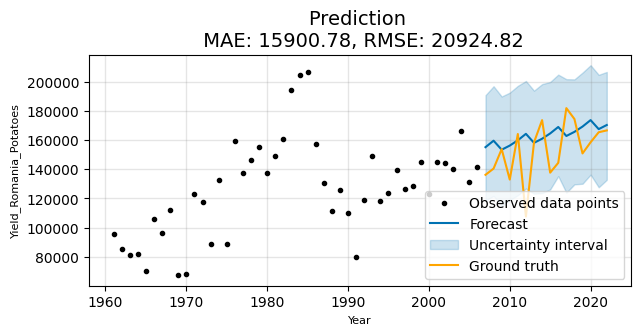

In [76]:
plot_prophet(TRAINED_MODELS['Yield_Romania_Potatoes'], *VALIDATION_DATA['Yield_Romania_Potatoes'], 'Yield_Romania_Potatoes')


### Creat EU Aggregate Model

In [77]:
EU_total_df_unstacked = df_unstacked[['year', 'item', 'Area harvested',	'Production', 'Yield']].groupby(by=['year', 'item'], as_index=False).sum()
EU_total_df_unstacked['area'] = 'EU'
EU_total_df_unstacked

element,year,item,Area harvested,Production,Yield,area
0,1961,"Almonds, in shell",562400.0,550938.0,28943.0,EU
1,1961,"Anise, badian, coriander, cumin, caraway, fenn...",6235.0,7866.0,43175.0,EU
2,1961,Apples,307333.0,5444625.0,1790429.0,EU
3,1961,Apricots,45787.0,343189.0,501417.0,EU
4,1961,Artichokes,80602.0,696409.0,456264.0,EU
...,...,...,...,...,...,...
6967,2022,"True hemp, raw or retted",26510.0,154830.0,395973.0,EU
6968,2022,Unmanufactured tobacco,42790.0,98470.0,182663.0,EU
6969,2022,"Walnuts, in shell",101150.0,238210.0,687808.0,EU
6970,2022,Watermelons,56960.0,2682310.0,5108280.0,EU


In [78]:
VALIDATION_DATA_EU, TRAINED_MODELS_EU = pre_train(EU_total_df_unstacked)

13:47:26 - cmdstanpy - INFO - Chain [1] start processing


(46, 2) 46 16


13:47:26 - cmdstanpy - INFO - Chain [1] done processing
13:47:26 - cmdstanpy - INFO - Chain [1] start processing


(69820.027941093, 86727.31748947635)
(46, 2) 46 16


13:47:27 - cmdstanpy - INFO - Chain [1] done processing
13:47:27 - cmdstanpy - INFO - Chain [1] start processing


(133672.84674888186, 152328.6588259423)
(46, 2) 46 16


13:47:27 - cmdstanpy - INFO - Chain [1] done processing
13:47:27 - cmdstanpy - INFO - Chain [1] start processing


(1129694.1462760763, 1291194.7861153702)
(46, 2) 46 16


13:47:28 - cmdstanpy - INFO - Chain [1] done processing
13:47:28 - cmdstanpy - INFO - Chain [1] start processing


(2194175.580421565, 2527666.5284536094)
(46, 2) 46 16


13:47:28 - cmdstanpy - INFO - Chain [1] done processing
13:47:29 - cmdstanpy - INFO - Chain [1] start processing


(143454.72423444883, 170485.58552001862)
(46, 2) 46 16


13:47:29 - cmdstanpy - INFO - Chain [1] done processing
13:47:29 - cmdstanpy - INFO - Chain [1] start processing


(2217480.5551777286, 2998350.466291455)
(46, 2) 46 16


13:47:29 - cmdstanpy - INFO - Chain [1] done processing
13:47:29 - cmdstanpy - INFO - Chain [1] start processing


(1832870.9723105938, 2045461.9651323652)
(46, 2) 46 16


13:47:30 - cmdstanpy - INFO - Chain [1] done processing
13:47:30 - cmdstanpy - INFO - Chain [1] start processing


(6549884.4995124815, 8357677.551071595)
(46, 2) 46 16


13:47:30 - cmdstanpy - INFO - Chain [1] done processing
13:47:30 - cmdstanpy - INFO - Chain [1] start processing


(19870567.31081619, 21672345.605318084)
(46, 2) 46 16


13:47:31 - cmdstanpy - INFO - Chain [1] done processing


(9785868.81024485, 11480889.22395587)


RMSE: 2998350.466291455
RMSE: 86727.31748947635


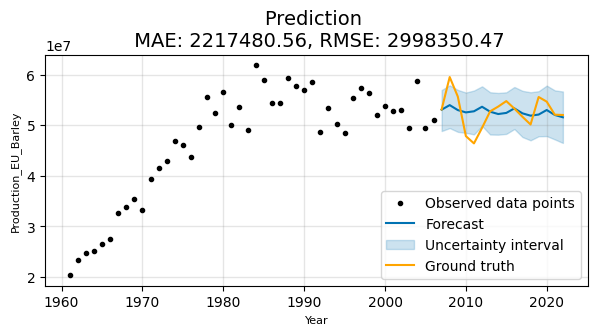

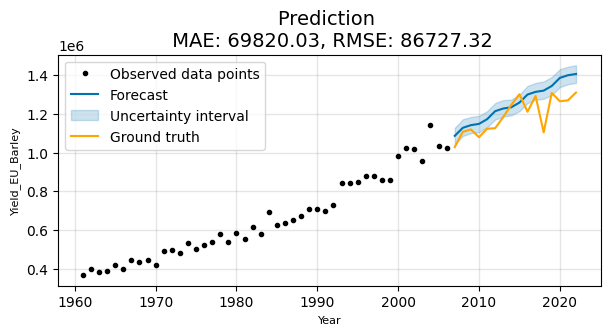

In [79]:
plot_prophet(TRAINED_MODELS_EU['Production_EU_Barley'], *VALIDATION_DATA_EU['Production_EU_Barley'], 'Production_EU_Barley')
plot_prophet(TRAINED_MODELS_EU['Yield_EU_Barley'], *VALIDATION_DATA_EU['Yield_EU_Barley'], 'Yield_EU_Barley')


In [80]:
# fig = px.choropleth(internet_usage_2016,
#                     locations="Code",
#                     color="Individuals using the Internet (% of population)", 
#                     # column by which to color-code
#                     hover_name="Country", 
#                     # column to display in hover information
#                     color_continuous_scale=px.colors.sequential.Plasma)
# fig.update_layout(
#     # add a title text for the plot
#     title_text = 'Internet usage across the Asian Continent (% population) - 2016',
#     geo_scope = 'north america' 
# # can be set to north america | south america | africa | asia | europe | usa
# )
# fig.show()

In [85]:
app_comp = Dash(__name__)

app_comp.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id="item",
            options=TOP_IRISH_CROPS_PRODUCTION,
            value="Barley",
        ),
    ], style={'width': '20%', 'display': 'inline-block', "borderColor": "#66c2a5"}),
    html.Div([
        dcc.Dropdown(
            id="metric",
            options=['Yield', 'Production'],
            value="Production",
        ),
    ], style={'width': '20%', 'display': 'inline-block', "borderColor": "#66c2a5"}),
    html.Div([
        dcc.Dropdown(
            id="area",
            options=df_unstacked.area.unique(),
            value="Ireland",
        ),
    ], style={'width': '20%', 'display': 'inline-block', "borderColor": "#66c2a5"}),
    html.Div([
        html.Div([
            dcc.RangeSlider(2022, 2050, 1, 
                            value=[2022, 2027], 
                            marks={i: '{}'.format(i) for i in range(2022, 2050)},
                            id='predict'),
        ], style={'width': '100%', 'display': 'inline-block', "padding": "10px"}),
    ]),
    html.Div([
        html.Div([
           dcc.Graph(id="graph"),
        ], style={'width': '100%', 'float': 'left'}),
    ])
], style={'backgroundColor': 'white'})


@app_comp.callback(
    Output("graph", "figure"),
    Input("item", "value"),
    Input("metric", "value"),
    Input("area", "value"),
    Input("predict", "value"),
    )
def update_line_chart(item, metric, area, predict):
    data = df_unstacked[(df_unstacked.area == area) & (df_unstacked.item == item)].reset_index().sort_values(by='year')
    
    n = f'{metric}_{area}_{item}'
    model = TRAINED_MODELS[n]

    if not model:
        with open(f'prophet_models/{n}.json', 'r') as fin:
            model = model_from_json(fin.read())  # Load model
    
    predict = list(range(predict[0], predict[1]+1))
    predict = data.year.unique().tolist() + predict

    forecast = model.predict(pd.DataFrame(predict, columns=['ds']))    

    trace = go.Scatter(
        name = 'Actual',
        mode = 'markers',
        x = list(forecast['ds']),
        y = list(data[metric]),
        marker=dict(
            color='#FFBAD2',
            line=dict(width=1)
        )
   )
    
    trace1 = go.Scatter(
        name = 'Predicted Trend',
        mode = 'lines',
        x = list(forecast['ds']),
        y = list(forecast['yhat']),
        marker=dict(
            color='red',
            line=dict(width=3)
        )
    )

    upper_band = go.Scatter(
        name = 'upper band',
        mode = 'lines',
        x = list(forecast['ds']),
        y = list(forecast['yhat_upper']),
        line= dict(color='#57b88f'),
            fill = 'tonexty'
    )

    lower_band = go.Scatter(
        name= 'lower band',
        mode = 'lines',
        x = list(forecast['ds']),
        y = list(forecast['yhat_lower']),
        line= dict(color='#1705ff')
    )

    data = [trace1, lower_band, upper_band, trace]

    layout = dict(title=f'{item} in {area} {metric} estimates Using Meta Prophet univariate model',
             xaxis=dict(title = 'Dates', ticklen=2, zeroline=True))

    figure=dict(data=data,layout=layout)

    return figure

app_comp.run_server(debug=True, port=8070)

## Sentiment Analysis

In [84]:
# https://www.kaggle.com/code/michawilkosz/twitter-sentiment-analysis-using-tensorflow
# https://github.com/reddit-archive/reddit/wiki/OAuth2#getting-started
# redirect URL http://localhost:8080

In [19]:
from os import getenv
from dotenv import load_dotenv
import pandas as pd
from datetime import datetime as dt
import praw

from praw.models import MoreComments
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

import requests
import time



#### Step 1: Developing the dataset

In [39]:
load_dotenv()

APP_NAME = getenv("APP_NAME")
APP_ID = getenv("APP_ID")
APP_SECRET = getenv("APP_SECRET")
REDDIT_NAME = getenv("REDDIT_NAME")
REDDIT_USERNAME = getenv("REDDIT_NAME")
REDDIT_PASSWORD = getenv("REDDIT_PASSWORD")
REDIRECT_URL = "http://localhost:8080"

False

In [ ]:
# https://github.com/reddit-archive/reddit/wiki/OAuth2-Python-Example
# https://www.reddit.com/r/redditdev/comments/64gsq0/need_help_with_search_api/
# https://www.reddit.com/r/redditdev/comments/16dt0wn/get_rsubredditsearch_not_working_as_expected/

In [76]:
access_token = get_token()
headers = {'Authorization': f"bearer {access_token}", 
           "Cache-Control": "no-cache, max-age=0", 
           'Connection':'close',
           'User-Agent': f'macOs:{APP_NAME}:v1.0 (by /u/{REDDIT_USERNAME})'}

subreddits = ['science', 'farming', 'ireland', 'Farmers']
queries = ['crop AND yield', 'yield AND wheat AND ireland', 'yield AND wheat AND USA', 'wheat AND price', 'barley AND price', 'agricultural AND price']
limit=100


posts = []

for subreddit in subreddits:
    print('********** SEARCHING THROUGH: ', subreddit.upper(), '********** \n')
    for query in queries:
        print('********** SEARCHING THROUGH: ', query.upper(), '********** \n')

        with requests.Session() as sess:
            adapter = requests.adapters.HTTPAdapter(max_retries=2)
            sess.mount('http://', adapter)
            
            res = sess.get(f"https://oauth.reddit.com/r/{subreddit}/search/?q={query}&limit={limit}&type=link&restrict_sr=true", headers=headers)
    
            print(res.status_code)
            if res.status_code == 200:
                parse_posts_results(query, posts, res)
        

********** SEARCHING THROUGH:  SCIENCE ********** 

********** SEARCHING THROUGH:  CROP AND YIELD ********** 

200
Potassium depletion in soil threatens global crop yields
Recent patterns of crop yield, growth, and stagnation: worldwide crop yields are decreasing
21 years of data confirm GMO corn increase crop yield, and provides substantial health benefits such as a reduction in exposure to mycotoxins
Study: Rice that is resistant to some of the worst crop-destroying diseases but can still produce large yields could soon become a reality for farmers worldwide. Rice crops with higher yields are needed to meet growing global demand and the results from this study could help shore up food supply.
Crops yields around the world could fall within a decade unless action is taken to speed up the introduction of new varieties. A study says temperatures are rising faster than the development of crop varieties that can cope with a warmer world.
Most crops are plagued by a photosynthetic glitch, 

In [78]:
posts_df = pd.DataFrame(posts, columns=['query', 'subreddit', 'id', 'title', 'num_comments', 'upvote_ratio', 'selftext', 'created_utc', 'url_overridden_by_dest'])
posts_df.head()

,query,subreddit,id,title,num_comments,upvote_ratio,selftext,created_utc,url_overridden_by_dest
0,crop AND yield,science,1ca0rmk,Potassium depletion in soil threatens global c...,130,0.97,,1.713757e+09,https://www.ucl.ac.uk/news/2024/feb/potassium-...
1,crop AND yield,science,15ty52,"Recent patterns of crop yield, growth, and sta...",719,0.88,,1.357145e+09,http://www.nature.com/ncomms/journal/v3/n12/fu...
2,crop AND yield,science,7ysj9i,21 years of data confirm GMO corn increase cro...,2394,0.85,,1.519094e+09,https://geneticliteracyproject.org/2018/02/19/...
3,crop AND yield,science,14efxze,Study: Rice that is resistant to some of the w...,491,0.95,,1.687279e+09,https://www.adelaide.edu.au/newsroom/news/list...
4,crop AND yield,science,4p1xr6,Crops yields around the world could fall withi...,826,0.87,,1.466470e+09,http://www.bbc.com/news/science-environment-36...


In [79]:
posts_df.to_csv('sentiment_data/posts/crop_yield.csv', index=False)

In [80]:
reddit = praw.Reddit(
    client_id = APP_ID,
    client_secret = APP_SECRET,
    user_agent = f"{APP_NAME} u/{REDDIT_NAME}"
)
print(reddit.read_only)

True


In [82]:
# https://www.reddit.com/dev/api/#POST_api_comment


def get_all_comments(comment, level, post_id, all_comments):
    if isinstance(comment, MoreComments): #https://praw.readthedocs.io/en/latest/tutorials/comments.html#extracting-comments-with-praw
        return
    
    try:
        all_comments.append([
            post_id,
            level,
            comment.body,
            comment.gilded,
            comment.likes,
            comment.num_reports,
            comment.score,
            comment.subreddit
        ])
    except Exception as e:
        print('Could not retries the comment, skipping. Error: ', e)

    if comment.replies:
        for reply in comment.replies:
            get_all_comments(reply, level + 1, post_id, all_comments)


In [85]:
NUM_COMM_THRESHOLD = 15

for post_id in posts_df.id:
    submission = reddit.submission(post_id)
    print('Post ID ', post_id, 'contains ', submission.num_comments, ' comments') # Will be used to validate the resulting dataframes and identify if some comments have been missed
    
    if submission.num_comments < NUM_COMM_THRESHOLD:
        continue

    all_comments = []
    for comment in submission.comments:        
        get_all_comments(comment, 0, post_id, all_comments)

    comments_pd = pd.DataFrame(all_comments, columns=[
            'post_id',
            'level',
            'body',
            'gilded',
            'likes',
            'num_reports',
            'score',
            'subreddit',
    ])
    comments_pd.to_csv(f"sentiment_data/comments/{post_id}.csv", index=False)
    time.sleep(1)

Post ID  1ca0rmk contains  130  comments
Post ID  15ty52 contains  719  comments
Post ID  7ysj9i contains  2394  comments
Post ID  14efxze contains  491  comments
Post ID  4p1xr6 contains  826  comments
Post ID  aca4z3 contains  986  comments
Post ID  bqa7v contains  157  comments
Post ID  10hso0q contains  44  comments
Post ID  ekx5wd contains  1151  comments
Post ID  wup9a4 contains  129  comments
Post ID  5a5qta contains  217  comments
Post ID  1bnhu2l contains  139  comments
Post ID  1clj88 contains  87  comments
Post ID  dhpj8d contains  66  comments
Post ID  v2nfvy contains  15  comments
Post ID  tbh780 contains  220  comments
Post ID  5dmadm contains  161  comments
Post ID  byo8pu contains  2577  comments
Post ID  1b8a9c0 contains  4  comments
Post ID  ampmxu contains  608  comments
Post ID  17jr299 contains  32  comments
Post ID  ldopk contains  32  comments
Post ID  82x4k9 contains  113  comments
Post ID  twjdmc contains  43  comments
Post ID  yhmhl5 contains  43  comments
Pos

### Step 1 [Alternative]: Load In The Dataset

When re-runing this notebook, we may not want to regenerate the dataset, as it is a long and costly procedure. 

Hence, we can just load in the dataset generated in step 1.

In [9]:
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

In [ ]:
# https://www.reddit.com/r/ireland/comments/16g9big/what_do_you_think_of_the_current_state_of_the/   ->> 62 comments
# https://www.reddit.com/r/ireland/comments/w0c2mx/popular_among_the_farming_community/ --->>> 457 comments

In [20]:
ALPHA_CHARS_REGEX = re.compile('[^a-zA-Z!?]')

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

lemmatizer = WordNetLemmatizer()

def clean_up_comment(comment):
    new_comment = []
    for word in comment.split(' '):
        word = ALPHA_CHARS_REGEX.sub('', word)
        word = lemmatizer.lemmatize(word)
        if word not in stopwords.words('english'):
            new_comment.append(word)
    return ' '.join(new_comment)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olenapleshan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
from datetime import datetime

In [41]:
posts_df = get_df_from_dir('sentiment_data/posts')
posts_df.shape

posts_df = posts_df.fillna('')
posts_df['title_clean'] = posts_df.title.apply(lambda x: clean_up_comment(x))
posts_df['created_date'] = posts_df.created_utc.apply(lambda ts: datetime.utcfromtimestamp(int(ts)).strftime('%Y'))

posts_df.head()


,query,subreddit,id,title,num_comments,upvote_ratio,selftext,created_utc,url_overridden_by_dest,title_clean,created_date
0,crop AND yield,science,1ca0rmk,Potassium depletion in soil threatens global c...,130,0.97,,1.713757e+09,https://www.ucl.ac.uk/news/2024/feb/potassium-...,Potassium depletion soil threatens global crop...,2024
1,crop AND yield,science,15ty52,"Recent patterns of crop yield, growth, and sta...",719,0.88,,1.357145e+09,http://www.nature.com/ncomms/journal/v3/n12/fu...,Recent pattern crop yield growth stagnation wo...,2013
2,crop AND yield,science,7ysj9i,21 years of data confirm GMO corn increase cro...,2394,0.85,,1.519094e+09,https://geneticliteracyproject.org/2018/02/19/...,year data confirm GMO corn increase crop yiel...,2018
3,crop AND yield,science,14efxze,Study: Rice that is resistant to some of the w...,491,0.95,,1.687279e+09,https://www.adelaide.edu.au/newsroom/news/list...,Study Rice resistant worst cropdestroying dise...,2023
4,crop AND yield,science,4p1xr6,Crops yields around the world could fall withi...,826,0.87,,1.466470e+09,http://www.bbc.com/news/science-environment-36...,Crops yield around world could fall within dec...,2016


In [50]:
sentiment_df = get_df_from_dir('sentiment_data/comments')
sentiment_df = sentiment_df.drop_duplicates().reset_index(drop=True)
sentiment_df = sentiment_df[sentiment_df.body.notna()].reset_index(drop=True)

sentiment_df.shape

sentiment_df = sentiment_df.fillna(0)
sentiment_df.head()
sentiment_df.tail()

2l9kwe.csv (16, 8)
1090mm8.csv (20, 8)
7oy2om.csv (17, 8)
yhmhl5.csv (26, 8)
ampmxu.csv (434, 8)
e7hp20.csv (451, 8)
1zirvh.csv (31, 8)
byo8pu.csv (455, 8)
tbh780.csv (181, 8)
tuu4wi.csv (23, 8)
12j986.csv (237, 8)
xgaz5y.csv (16, 8)
5a5qta.csv (192, 8)
16sy4kk.csv (46, 8)
82x4k9.csv (74, 8)
18npogo.csv (39, 8)
twjdmc.csv (22, 8)
9xbpcz.csv (35, 8)
52k6w9.csv (52, 8)
9btczj.csv (18, 8)
51f76x.csv (22, 8)
8th4n.csv (30, 8)
251c4o.csv (85, 8)
1ca0rmk.csv (118, 8)
q9kr9c.csv (29, 8)
4451rm.csv (106, 8)
4p1xr6.csv (279, 8)
5dmadm.csv (110, 8)
9tlc13.csv (57, 8)
ohaqax.csv (34, 8)
10hso0q.csv (36, 8)
12uqvu8.csv (414, 8)
15thexi.csv (36, 8)
jsclq2.csv (26, 8)
gs5kli.csv (21, 8)
1clj88.csv (95, 8)
7ysj9i.csv (433, 8)
17wma3.csv (36, 8)
oczl75.csv (406, 8)
5igqkg.csv (70, 8)
p5nl08.csv (159, 8)
1bnhu2l.csv (102, 8)
2ouluy.csv (22, 8)
hrzfqn.csv (108, 8)
bqa7v.csv (163, 8)
h6wir.csv (46, 8)
160jg21.csv (60, 8)
opiawm.csv (97, 8)
w6cm3u.csv (21, 8)
18vvokh.csv (17, 8)
x5t4rm.csv (96, 8)
3odpha.

(8896, 8)

,post_id,level,body,gilded,likes,num_reports,score,subreddit
0,2l9kwe,0,"It's not a competition, molecules.",0.0,0.0,0,21.0,science
1,2l9kwe,1,"In particular, air pollution (soot and ground ...",0.0,0.0,0,14.0,science
2,2l9kwe,1,Tell that to carbon monoxide! The little basta...,0.0,0.0,0,2.0,science
3,2l9kwe,0,I'm curious on if they are talking about poten...,0.0,0.0,0,5.0,science
4,2l9kwe,1,A 32% decrease in total actual yield would hav...,0.0,0.0,0,9.0,science


,post_id,level,body,gilded,likes,num_reports,score,subreddit
8891,uuju1a,0,It's concerning but I see little reason to wor...,0.0,0.0,0,1.0,ireland
8892,uuju1a,0,"kind of, but climate change is something only ...",0.0,0.0,0,1.0,ireland
8893,uuju1a,0,"No, we went from 990 million to 8 billion in 2...",0.0,0.0,0,1.0,ireland
8894,uuju1a,0,Very and have been for about 20 odd years.\n\n...,0.0,0.0,0,1.0,ireland
8895,uuju1a,0,Make sure to subscribe to r/ClimateActionPlan ...,0.0,0.0,0,1.0,ireland


In [51]:
# Clean Up
sentiment_df['body_clean'] = sentiment_df.body.apply(lambda x: clean_up_comment(x))

In [52]:
sentiment_df.head()
sentiment_df.tail()


,post_id,level,body,gilded,likes,num_reports,score,subreddit,body_clean
0,2l9kwe,0,"It's not a competition, molecules.",0.0,0.0,0,21.0,science,Its competition molecule
1,2l9kwe,1,"In particular, air pollution (soot and ground ...",0.0,0.0,0,14.0,science,In particular air pollution soot ground level ...
2,2l9kwe,1,Tell that to carbon monoxide! The little basta...,0.0,0.0,0,2.0,science,Tell carbon monoxide! The little bastard effec...
3,2l9kwe,0,I'm curious on if they are talking about poten...,0.0,0.0,0,5.0,science,Im curious talking potential yield opposed act...
4,2l9kwe,1,A 32% decrease in total actual yield would hav...,0.0,0.0,0,9.0,science,A decrease total actual yield would caused wi...


,post_id,level,body,gilded,likes,num_reports,score,subreddit,body_clean
8891,uuju1a,0,It's concerning but I see little reason to wor...,0.0,0.0,0,1.0,ireland,Its concerning I see little reason worry somet...
8892,uuju1a,0,"kind of, but climate change is something only ...",0.0,0.0,0,1.0,ireland,kind climate change something solve idea child...
8893,uuju1a,0,"No, we went from 990 million to 8 billion in 2...",0.0,0.0,0,1.0,ireland,No went million billion year No amount wash...
8894,uuju1a,0,Very and have been for about 20 odd years.\n\n...,0.0,0.0,0,1.0,ireland,Very odd yearsThis great illustration grave t...
8895,uuju1a,0,Make sure to subscribe to r/ClimateActionPlan ...,0.0,0.0,0,1.0,ireland,Make sure subscribe rClimateActionPlan concern...


### Step 2.1: Vader (Valence Aware Dictionary and sEntiment Reasoner)

In [28]:
# DO NOT FORGET TO CITE THIS in the REPORT!!!
# https://github.com/cjhutto/vaderSentiment?tab=readme-ov-file#citation-information

In [53]:
# Documentation https://www.nltk.org/_modules/nltk/sentiment/vader.html

nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

scores_ser = sentiment_df.body.apply(lambda comment: analyzer.polarity_scores(comment))
scores_ser


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/olenapleshan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

0       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1       {'neg': 0.016, 'neu': 0.905, 'pos': 0.079, 'co...
2       {'neg': 0.124, 'neu': 0.876, 'pos': 0.0, 'comp...
3       {'neg': 0.0, 'neu': 0.969, 'pos': 0.031, 'comp...
4       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                              ...                        
8891    {'neg': 0.176, 'neu': 0.769, 'pos': 0.056, 'co...
8892    {'neg': 0.152, 'neu': 0.678, 'pos': 0.17, 'com...
8893    {'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'comp...
8894    {'neg': 0.196, 'neu': 0.64, 'pos': 0.164, 'com...
8895    {'neg': 0.086, 'neu': 0.674, 'pos': 0.24, 'com...
Name: body, Length: 8896, dtype: object

In [54]:
sentiment_df = pd.concat([sentiment_df, pd.DataFrame(list(scores_ser))[['compound']]], axis=1)
sentiment_df.rename(columns={'compound': 'vader_compound'}, inplace=True)
sentiment_df.head()

,post_id,level,body,gilded,likes,num_reports,score,subreddit,body_clean,vader_compound
0,2l9kwe,0,"It's not a competition, molecules.",0.0,0.0,0,21.0,science,Its competition molecule,0.0000
1,2l9kwe,1,"In particular, air pollution (soot and ground ...",0.0,0.0,0,14.0,science,In particular air pollution soot ground level ...,0.7673
2,2l9kwe,1,Tell that to carbon monoxide! The little basta...,0.0,0.0,0,2.0,science,Tell carbon monoxide! The little bastard effec...,-0.3994
3,2l9kwe,0,I'm curious on if they are talking about poten...,0.0,0.0,0,5.0,science,Im curious talking potential yield opposed act...,0.3182
4,2l9kwe,1,A 32% decrease in total actual yield would hav...,0.0,0.0,0,9.0,science,A decrease total actual yield would caused wi...,0.0000


In [64]:
scores_ser = sentiment_df.body_clean.apply(lambda comment: analyzer.polarity_scores(comment))
sentiment_df = pd.concat([sentiment_df, pd.DataFrame(list(scores_ser))[['compound']]], axis=1)
sentiment_df.rename(columns={'compound': 'vader_compound_clean'}, inplace=True)
sentiment_df.head()
sentiment_df.tail()

,post_id,level,body,gilded,likes,num_reports,score,subreddit,body_clean,vader_compound,clean_vader_compound,vader_label,clean_vader_label,vader_label_clean,vader_compound_clean
0,2l9kwe,0,"It's not a competition, molecules.",0.0,0.0,0,21.0,science,Its competition molecule,0.0000,0.0000,neutral,neutral,neutral,0.0000
1,2l9kwe,1,"In particular, air pollution (soot and ground ...",0.0,0.0,0,14.0,science,In particular air pollution soot ground level ...,0.7673,0.8689,positive,positive,positive,0.8689
2,2l9kwe,1,Tell that to carbon monoxide! The little basta...,0.0,0.0,0,2.0,science,Tell carbon monoxide! The little bastard effec...,-0.3994,-0.5846,negative,negative,negative,-0.5846
3,2l9kwe,0,I'm curious on if they are talking about poten...,0.0,0.0,0,5.0,science,Im curious talking potential yield opposed act...,0.3182,0.5719,positive,positive,positive,0.5719
4,2l9kwe,1,A 32% decrease in total actual yield would hav...,0.0,0.0,0,9.0,science,A decrease total actual yield would caused wi...,0.0000,0.0000,neutral,neutral,neutral,0.0000


,post_id,level,body,gilded,likes,num_reports,score,subreddit,body_clean,vader_compound,clean_vader_compound,vader_label,clean_vader_label,vader_label_clean,vader_compound_clean
8891,uuju1a,0,It's concerning but I see little reason to wor...,0.0,0.0,0,1.0,ireland,Its concerning I see little reason worry somet...,-0.9537,-0.8891,negative,negative,negative,-0.8891
8892,uuju1a,0,"kind of, but climate change is something only ...",0.0,0.0,0,1.0,ireland,kind climate change something solve idea child...,-0.2238,0.4767,neutral,positive,positive,0.4767
8893,uuju1a,0,"No, we went from 990 million to 8 billion in 2...",0.0,0.0,0,1.0,ireland,No went million billion year No amount wash...,-0.5267,-0.5267,negative,negative,negative,-0.5267
8894,uuju1a,0,Very and have been for about 20 odd years.\n\n...,0.0,0.0,0,1.0,ireland,Very odd yearsThis great illustration grave t...,0.0516,0.0440,neutral,neutral,neutral,0.0440
8895,uuju1a,0,Make sure to subscribe to r/ClimateActionPlan ...,0.0,0.0,0,1.0,ireland,Make sure subscribe rClimateActionPlan concern...,0.6249,0.6808,positive,positive,positive,0.6808


In [109]:
#pip install datasets transformers huggingface_hub

##### Label the comments with a category for the whole comment

In [65]:
def compound_score_to_label(score):
    if score >= 0.25:
        return 'positive'
    if score <= -0.25:
        return 'negative'
    return 'neutral'

sentiment_df['vader_label'] = sentiment_df.vader_compound.apply(lambda score: compound_score_to_label(score))
sentiment_df['vader_label_clean'] = sentiment_df.vader_compound_clean.apply(lambda score: compound_score_to_label(score))
sentiment_df.head()

,post_id,level,body,gilded,likes,num_reports,score,subreddit,body_clean,vader_compound,clean_vader_compound,vader_label,clean_vader_label,vader_label_clean,vader_compound_clean
0,2l9kwe,0,"It's not a competition, molecules.",0.0,0.0,0,21.0,science,Its competition molecule,0.0000,0.0000,neutral,neutral,neutral,0.0000
1,2l9kwe,1,"In particular, air pollution (soot and ground ...",0.0,0.0,0,14.0,science,In particular air pollution soot ground level ...,0.7673,0.8689,positive,positive,positive,0.8689
2,2l9kwe,1,Tell that to carbon monoxide! The little basta...,0.0,0.0,0,2.0,science,Tell carbon monoxide! The little bastard effec...,-0.3994,-0.5846,negative,negative,negative,-0.5846
3,2l9kwe,0,I'm curious on if they are talking about poten...,0.0,0.0,0,5.0,science,Im curious talking potential yield opposed act...,0.3182,0.5719,positive,positive,positive,0.5719
4,2l9kwe,1,A 32% decrease in total actual yield would hav...,0.0,0.0,0,9.0,science,A decrease total actual yield would caused wi...,0.0000,0.0000,neutral,neutral,neutral,0.0000


##### Step 2.3. Save the labelled data

In [58]:
sentiment_df.to_csv('sentiment_data/sentiment_labelled.csv')

In [75]:
max_score

7017.0

In [80]:
%time

min_score = min(sentiment_df.score)
max_score = max(sentiment_df.score)

pd.set_option('display.max_colwidth', None)

@interact
def view_sentiment(vader_label=['positive', 'neutral', 'negative'],
                   score=widgets.IntSlider(min=min_score, max=max_score, step=1, value=min_score),
                   body_search=''
                   ):
    return sentiment_df[(sentiment_df.score >= score) & (sentiment_df.vader_label_clean == vader_label) & (sentiment_df.body_clean.str.contains(body_search))][['body', 'subreddit']]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


interactive(children=(Dropdown(description='vader_label', options=('positive', 'neutral', 'negative'), value='…

In [ ]:
pd.set_option('display.max_colwidth', 50)

### Step 2.2. BERT 

In [135]:
# !pip install datasets transformers huggingface_hub

In [ ]:
# https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis
# https://github.com/pysentimiento/pysentimiento

In [59]:
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification
import torch

torch.cuda.is_available()

False

In [60]:
sentiment_df_sample = sentiment_df.sample(n=100, random_state=1).reset_index(drop=True)
sentiment_df_sample.head()

,post_id,level,body,gilded,likes,num_reports,score,subreddit,body_clean,vader_compound,clean_vader_compound,vader_label,clean_vader_label
0,12j986,4,still are.,0.0,0.0,0,1.0,science,still,0.0000,0.0000,neutral,neutral
1,3odpha,1,I'm all for vaccination against deadly disease...,0.0,0.0,0,1.0,science,Im vaccination deadly disease I NOT sold GMO s...,0.2023,-0.4767,neutral,negative
2,aca4z3,0,So when can I get some weed like this?,0.0,0.0,0,1.0,science,So I get weed like this?,0.3612,0.4144,positive,positive
3,ohaqax,3,"Definitely wheat beer, that’s my favorite kind",0.0,0.0,0,1.0,farming,Definitely wheat beer thats favorite kind,0.8442,0.8442,positive,positive
4,oczl75,4,Literally a Captain Planet villain.,0.0,0.0,0,3.0,science,Literally Captain Planet villain,-0.5574,-0.5574,negative,negative


In [61]:
bert_sentiment_analysis = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [62]:
%time
scores_bert = []

# Map to normalize labels provided by bertweet-base-sentiment-analysis model to Vader labels
label_norm_map = {
    'NEU': 'neutral',
    'POS': 'positive',
    'NEG': 'negative',
}

for comment in sentiment_df_sample.body.to_list():
    scores = {}
    try:
        score = bert_sentiment_analysis(comment)
        scores['bert_label'] = label_norm_map[score[0]['label']]
        scores['bert_score'] = score[0]['score']
    except Exception as e:
        scores['bert_label'] = '', 
        scores['bert_score'] = 0
    scores_bert.append(scores)

scores_bert_df = pd.DataFrame(list(scores_bert))
sentiment_df_sample = pd.concat([sentiment_df_sample, scores_bert_df], axis=1)
sentiment_df_sample.head()

CPU times: user 5 µs, sys: 3 µs, total: 8 µs
Wall time: 55.1 µs


Token indices sequence length is longer than the specified maximum sequence length for this model (399 > 128). Running this sequence through the model will result in indexing errors


,post_id,level,body,gilded,likes,num_reports,score,subreddit,body_clean,vader_compound,clean_vader_compound,vader_label,clean_vader_label,bert_label,bert_score
0,12j986,4,still are.,0.0,0.0,0,1.0,science,still,0.0000,0.0000,neutral,neutral,neutral,0.926423
1,3odpha,1,I'm all for vaccination against deadly disease...,0.0,0.0,0,1.0,science,Im vaccination deadly disease I NOT sold GMO s...,0.2023,-0.4767,neutral,negative,negative,0.893578
2,aca4z3,0,So when can I get some weed like this?,0.0,0.0,0,1.0,science,So I get weed like this?,0.3612,0.4144,positive,positive,neutral,0.965949
3,ohaqax,3,"Definitely wheat beer, that’s my favorite kind",0.0,0.0,0,1.0,farming,Definitely wheat beer thats favorite kind,0.8442,0.8442,positive,positive,positive,0.991819
4,oczl75,4,Literally a Captain Planet villain.,0.0,0.0,0,3.0,science,Literally Captain Planet villain,-0.5574,-0.5574,negative,negative,neutral,0.875666


In [24]:
sentiment_df_sample.to_csv('sentiment_data/sentiment_sample_labelled.csv')

,post_id,level,body,gilded,likes,num_reports,score,subreddit,body_clean,vader_compound,clean_vader_compound,vader_label,clean_vader_label
0,12j986,4,still are.,0.0,0.0,0,1.0,science,still,0.0000,0.0000,neutral,neutral
1,3odpha,1,I'm all for vaccination against deadly disease...,0.0,0.0,0,1.0,science,Im vaccination deadly disease I NOT sold GMO s...,0.2023,-0.4767,neutral,negative
2,aca4z3,0,So when can I get some weed like this?,0.0,0.0,0,1.0,science,So I get weed like this?,0.3612,0.4144,positive,positive
3,ohaqax,3,"Definitely wheat beer, that’s my favorite kind",0.0,0.0,0,1.0,farming,Definitely wheat beer thats favorite kind,0.8442,0.8442,positive,positive
4,oczl75,4,Literally a Captain Planet villain.,0.0,0.0,0,3.0,science,Literally Captain Planet villain,-0.5574,-0.5574,negative,negative


In [132]:
#https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=fH8xHMfdX974
# https://huggingface.co/blog/sentiment-analysis-python#4-analyzing-tweets-with-sentiment-analysis-and-python

In [ ]:
model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

In [ ]:
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
results = nlp(sentiment_df_sample.body_clean.to_list())

In [33]:
scores_bert_df = pd.DataFrame(list(results))
scores_bert_df.rename(columns={'label': 'bert_fin_label', 'score': 'bert_fin_score'}, inplace=True)
sentiment_df_sample = pd.concat([sentiment_df_sample, scores_bert_df], axis=1)
sentiment_df_sample.head()

,post_id,level,body,gilded,likes,num_reports,score,subreddit,body_clean,vader_compound,clean_vader_compound,vader_label,clean_vader_label,bert_label,bert_score,label,score,bert_fin_label,bert_fin_score
0,12j986,4,still are.,0.0,0.0,0,1.0,science,still,0.0000,0.0000,neutral,neutral,NEU,0.926423,neutral,0.997394,neutral,0.997394
1,3odpha,1,I'm all for vaccination against deadly disease...,0.0,0.0,0,1.0,science,Im vaccination deadly disease I NOT sold GMO s...,0.2023,-0.4767,neutral,negative,NEG,0.893578,negative,0.978423,negative,0.978423
2,aca4z3,0,So when can I get some weed like this?,0.0,0.0,0,1.0,science,So I get weed like this?,0.3612,0.4144,positive,positive,NEU,0.965949,neutral,0.998994,neutral,0.998994
3,ohaqax,3,"Definitely wheat beer, that’s my favorite kind",0.0,0.0,0,1.0,farming,Definitely wheat beer thats favorite kind,0.8442,0.8442,positive,positive,POS,0.991819,neutral,0.999714,neutral,0.999714
4,oczl75,4,Literally a Captain Planet villain.,0.0,0.0,0,3.0,science,Literally Captain Planet villain,-0.5574,-0.5574,negative,negative,NEU,0.875666,neutral,0.999640,neutral,0.999640


### Step 3: Topic Modelling

In [ ]:
# Topic modelling
# https://deepgram.com/learn/python-topic-modeling-with-a-bert-model

In [5]:
# pip install bertopic

In [6]:
posts_df.head()


,query,subreddit,id,title,num_comments,upvote_ratio,selftext,created_utc,url_overridden_by_dest
0,crop AND yield,science,1ca0rmk,Potassium depletion in soil threatens global c...,130,0.97,NaN,1.713757e+09,https://www.ucl.ac.uk/news/2024/feb/potassium-...
1,crop AND yield,science,15ty52,"Recent patterns of crop yield, growth, and sta...",719,0.88,NaN,1.357145e+09,http://www.nature.com/ncomms/journal/v3/n12/fu...
2,crop AND yield,science,7ysj9i,21 years of data confirm GMO corn increase cro...,2394,0.85,NaN,1.519094e+09,https://geneticliteracyproject.org/2018/02/19/...
3,crop AND yield,science,14efxze,Study: Rice that is resistant to some of the w...,491,0.95,NaN,1.687279e+09,https://www.adelaide.edu.au/newsroom/news/list...
4,crop AND yield,science,4p1xr6,Crops yields around the world could fall withi...,826,0.87,NaN,1.466470e+09,http://www.bbc.com/news/science-environment-36...


In [12]:
# !!!!!!!!!!!!!!!!!!!
# https://medium.com/@corymaklin/latent-dirichlet-allocation-dfcea0b1fddc

In [11]:
from bertopic import BERTopic


2024-05-22 19:30:56.083602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model = BERTopic()
topics, probs = model.fit_transform(posts_df.title_clean)

In [ ]:
# https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-hierarchical-documents

In [27]:
model.get_topic_freq()
model.get_topic_info()
model.visualize_topics()


,Topic,Count
0,-1,77
6,0,37
3,1,24
2,2,23
1,3,21
5,4,12
4,5,11


,Topic,Count,Name,Representation,Representative_Docs
0,-1,77,-1_yield_crop_soil_pollution,"[yield, crop, soil, pollution, corn, increase,...",[Study Rice resistant worst cropdestroying dis...
1,0,37,0_farmer_crop_crops_farm,"[farmer, crop, crops, farm, fertilizer, are, o...",[Im knowledgeable person come farming How farm...
2,1,24,1_crop_photosynthesis_plant_gene,"[crop, photosynthesis, plant, gene, yield, bre...",[Science AMA Series Im Christine Raines Profes...
3,2,23,2_climate_change_temperature_crop,"[climate, change, temperature, crop, world, yi...",[Study found changing global climate especiall...
4,3,21,3_soybean_yield_crop_seed,"[soybean, yield, crop, seed, forecast, stagnat...",[Seed yield seed quality profitability risk an...
5,4,12,4_cover_nitrate_crop_yield,"[cover, nitrate, crop, yield, system, reducing...",[New research show cover crop support higher y...
6,5,11,5_pest_insect_bee_abundance,"[pest, insect, bee, abundance, study, yield, c...",[Global Warming Means More Insects Threatening...


In [31]:
# Run the visualization with the original embeddings
embeddings = model._extract_embeddings(posts_df.title_clean, method="document")
model.visualize_documents(posts_df.title_clean, embeddings=embeddings)

In [30]:
model.visualize_barchart()

In [48]:
topics_over_time = model.topics_over_time(posts_df.title_clean, posts_df.created_date)
model.visualize_topics_over_time(topics_over_time)

### Bag of Words & CountVectorizer

In [70]:
# Instantiate an object cv by calling a method named as CountVectorzer()
cv = CountVectorizer(max_features = 3000, stop_words = list(set(stopwords.words('english'))))

# Train the dataset by calling a fit_transform() method
X_comments = cv.fit_transform(sentiment_df.body_clean).toarray()
# Display the rows and colums
X_comments.shape
Y_comments = sentiment_df.vader_label_clean

X_train, X_test, y_train, y_test = train_test_split(X_comments, Y_comments, test_size = 0.3)

(8896, 3000)

In [71]:
# Instantiate an object model by calling a method MultinomialNB()
model = MultinomialNB()

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report

# Instantiate a mthod named as Cla
cf = classification_report(y_test, y_pred, output_dict=True)


MultinomialNB()

<Axes: >

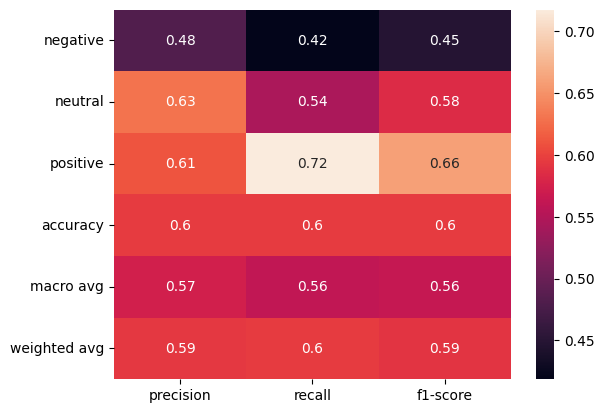

In [72]:
sns.heatmap(
    pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T.iloc[0:6, 0:3], 
    annot=True)


In [37]:
comment = 'agriculture here is a joke'
model.predict_proba(cv.transform([comment]))

array([[0.01477156, 0.82816794, 0.1570605 ]])